# Supervised Stylometric Analysis of the Pentateuch

This notebook runs the supervised boosting method used in supervised.pynb multiple times and averages the results to ensure the best consistency possible. The results from this notebook are presented in the writeup. Supervised.pynb provides a more thorough explanation of the methods used here, runs much quicker, and is more readable. Please reference that notebook instead. 

In [1]:
import numpy as np
import pandas as pd 
import itertools
import random

import fasttext
import xgboost as xgb
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn import ensemble, linear_model, metrics, model_selection, naive_bayes, svm
from gensim.models import Word2Vec, word2vec, KeyedVectors

import seaborn as sns
import matplotlib.pyplot as plt

color = sns.color_palette()
np.set_printoptions(suppress=True)
%matplotlib inline

In [2]:
def runAlgo(algo, x_train, y_train, x_test, y_test, x2_test):
    """ 
    Helper function to simplify changing algorithms while testing.
    Only pass MNB, RF, LR, SVM as algo argument.
    Call runFastText and runXGB as a standalone.
    """
    
    return algo(x_train, y_train, x_test, y_test, x2_test)

In [3]:
def runMNB(x_train, y_train, x_test, y_test, x2_test):
    
    model = naive_bayes.MultinomialNB()
    model.fit(x_train, y_train)
    y_pred_test = model.predict_proba(x_test)
    y2_pred_test = model.predict_proba(x2_test)
    return y_pred_test, y2_pred_test, model

In [4]:
def runRandomForest(x_train, y_train, x_test, y_test, x2_test):
    
    model = ensemble.RandomForestClassifier(n_estimators=500, n_jobs=-1)
    model.fit(x_train, y_train)
    y_pred_test = model.predict_proba(x_test)
    y2_pred_test = model.predict_proba(x2_test)
    return y_pred_test, y2_pred_test, model

In [5]:
def runLogisticRegression(x_train, y_train, x_test, y_test, x2_test):
    
    model = linear_model.LogisticRegression(max_iter=10000)
    model.fit(x_train, y_train)
    y_pred_test = model.predict_proba(x_test)
    y2_pred_test = model.predict_proba(x2_test)
    return y_pred_test, y2_pred_test, model

In [6]:
def runSVM(x_train, y_train, x_test, y_test, x2_test):
    
    model = CalibratedClassifierCV(svm.SVC(kernel='poly', degree=4))
    model.fit(x_train, y_train)
    y_pred_test = model.predict_proba(x_test)
    y2_pred_test = model.predict_proba(x2_test)
    return y_pred_test, y2_pred_test, model

In [7]:
def runFastText(k, x_train, y_train, x_test, y_test, x2_test):
    
    f = open('fasttext_data.txt', 'w')
    for x, y in zip(x_train, y_train):
        line = '__label__' + str(y) + ' ' + x + '\n'
        f.write(line)
    f.close()

    model = fasttext.train_supervised(input='fasttext_data.txt', epoch=50, lr=1, wordNgrams=20,  minn=3, maxn=6, dim=100)
    
    y_pred_test = []
    labels, probs = model.predict(x_test, k=k)
    for label, prob in zip(labels, probs):
        p = [x for _, x in sorted(zip(label, prob))]
        y_pred_test.append(p)
    y_pred_test = np.array(y_pred_test)
    
    y2_pred_test = []
    labels, probs = model.predict(x2_test, k=k)
    for label, prob in zip(labels, probs):
        p = [x for _, x in sorted(zip(label, prob))]
        y2_pred_test.append(p)
    y2_pred_test = np.array(y2_pred_test)
    
    return y_pred_test, y2_pred_test, model

In [8]:
def runXGB(k, num_rounds, param, x_train, y_train, x_test, y_test=None, x2_test=None):
    
    plst = list(param.items())
    xgtrain = xgb.DMatrix(x_train, label=y_train)

    if y_test is not None:
        xgtest = xgb.DMatrix(x_test, label=y_test)
        watchlist = [(xgtrain,'train'), (xgtest, 'test')]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(x_test)
        model = xgb.train(plst, xgtrain, num_rounds)

    y_pred_test = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if x2_test is not None:
        xgtest2 = xgb.DMatrix(x2_test)
        y2_pred_test = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return y_pred_test, y2_pred_test, model

In [9]:
def word_vector(model, tokens, dim):
    """ 
    Generate a word vector.
    model: a completed model
    tokens: a list of words (in this case POS)
    dim: Number of dimensions. 100 - 300 is good for w2v
    """
    
    i = 0
    vec = np.zeros(dim).reshape((1, dim))
    for word in tokens:
        vec += model[word].reshape((1, dim))
        i += 1.
    if i != 0:
        vec /= i
    return vec

In [10]:
# From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [11]:
df = pd.read_csv('data.csv')
print(df.loc[267, 'hebrew'])
print()
df = df[df['book'] != 'Deuteronomy']
df.head()

וֽ͏ַיְהִ֥י כָל־ הָאָ֖רֶץ שָׂפָ֣ה אֶחָ֑ת וּדְבָרִ֖ים אֲחָדִֽים׃



,Unnamed: 0,book,book_num,chapter,verse,hebrew,heb_no_niqquid_punct,web,pos,dh_author,sh_author
0,0,Genesis,1,1,1,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,בראשית ברא אלהים את השמים ואת הארץ,"In the beginning God{After ""God,"" the Hebrew h...",prep subs.f.sg.a verb.qal.perf.p3.m.sg subs.m....,P,P
1,1,Genesis,1,1,2,וְהָאָ֗רֶץ הָיְתָ֥ה תֹ֙הוּ֙ וָבֹ֔הוּ וְחֹ֖שֶׁך...,והארץ היתה תהו ובהו וחשך על פני תהום ורוח אלהי...,Now the earth was formless and empty. Darkness...,conj art subs.u.sg.a verb.qal.perf.p3.f.sg sub...,P,P
2,2,Genesis,1,1,3,וַיֹּ֥אמֶר אֱלֹהִ֖ים יְהִ֣י א֑וֹר וַֽיְהִי־ אֽ...,ויאמר אלהים יהי אור ויהי אור,"God said, ""Let there be light,"" and there was ...",conj verb.qal.wayq.p3.m.sg subs.m.pl.a verb.qa...,P,P
3,3,Genesis,1,1,4,וַיַּ֧רְא אֱלֹהִ֛ים אֶת־ הָא֖וֹר כִּי־ ט֑וֹב ו...,וירא אלהים את האור כי טוב ויבדל אלהים בין האור...,"God saw the light, and saw that it was good. G...",conj verb.qal.wayq.p3.m.sg subs.m.pl.a prep ar...,P,P
4,4,Genesis,1,1,5,וַיִּקְרָ֨א אֱלֹהִ֤ים ׀ לָאוֹר֙ י֔וֹם וְלַחֹ֖ש...,ויקרא אלהים לאור יום ולחשך קרא לילה ויהי ערב ו...,"God called the light Day, and the darkness he ...",conj verb.qal.wayq.p3.m.sg subs.m.pl.a prep ar...,P,P


In [12]:
xgb_dh_log_loss = []
xgb_sh_log_loss = []
xgb_dh_accuracy = []
xgb_sh_accuracy = []

cnf_dh_matrices = []
cnf_sh_matrices = []
cnf_hybrid_matrices = []

for run_num in range(25):
    print()
    print(run_num)
        
    seed = random.randint(0, 99999)
    print(seed)
    
    df = shuffle(df, random_state=seed)

    # Create true labels
    pos = df['pos'].tolist()
    heb = df['heb_no_niqquid_punct'].tolist()
    dh_author = df['dh_author']
    sh_author = df['sh_author']

    dh_to_int = {
        'J': 0,
        'E': 1,
        'P': 2, 
        'R': 3,
    }
    dh_labels = []
    for label in dh_author:
        dh_labels.append(dh_to_int[label])
    df['dh_labels'] = dh_labels
    dh_labels = np.array(dh_labels)

    sh_to_int = {
        'J': 0,
        'P': 1, 
    }
    sh_labels = []
    for label in sh_author:
        sh_labels.append(sh_to_int[label])
    df['sh_labels'] = sh_labels
    sh_labels = np.array(sh_labels)

    train_sh_df = pd.DataFrame()
    train_dh_df = pd.DataFrame()
    test_sh_df = pd.DataFrame()
    test_dh_df = pd.DataFrame()

    x_train, x_test, y_dh_train, y_dh_test = train_test_split(pos, dh_labels, test_size=0.2, random_state=seed)
    x_train, x_test, y_sh_train, y_sh_test = train_test_split(pos, sh_labels, test_size=0.2, random_state=seed)

    tfidf_vec = TfidfVectorizer(ngram_range=(2, 2))
    full_tfidf = tfidf_vec.fit_transform(pos)
    train_tfidf = tfidf_vec.transform(x_train)
    test_tfidf = tfidf_vec.transform(x_test)

    k = 4
    n_splits = 5
    y_train = y_dh_train
    algo = runSVM

    cv_log_loss = []
    cv_accuracy = []
    pred_full_test = 0
    pred_train = np.zeros([len(x_train), k])
    kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for dev_index, val_index in kf.split(x_train):
        x_dev, x_val = train_tfidf[dev_index], train_tfidf[val_index]
        y_dev, y_val = y_train[dev_index], y_train[val_index]
        y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, test_tfidf)
        pred_full_test = pred_full_test + y_pred_test
        pred_train[val_index, :] = y_pred_val
        cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
        cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
    pred_full_test = pred_full_test / n_splits
    print('Mean cv log loss: ', np.mean(cv_log_loss))
    print('Mean cv accuracy: ', np.mean(cv_accuracy))

    train_dh_df['svm_tfidf_j'] = pred_train[:, 0]
    train_dh_df['svm_tfidf_e'] = pred_train[:, 1]
    train_dh_df['svm_tfidf_p'] = pred_train[:, 2]
    train_dh_df['svm_tfidf_r'] = pred_train[:, 3]
    test_dh_df['svm_tfidf_j'] = pred_full_test[:, 0]
    test_dh_df['svm_tfidf_e'] = pred_full_test[:, 1]
    test_dh_df['svm_tfidf_p'] = pred_full_test[:, 2]
    test_dh_df['svm_tfidf_r'] = pred_full_test[:, 3]

    k = 2
    n_splits = 5
    y_train = y_sh_train
    algo = runSVM

    cv_log_loss = []
    cv_accuracy = []
    pred_full_test = 0
    pred_train = np.zeros([len(x_train), k])
    kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for dev_index, val_index in kf.split(x_train):
        x_dev, x_val = train_tfidf[dev_index], train_tfidf[val_index]
        y_dev, y_val = y_train[dev_index], y_train[val_index]
        y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, test_tfidf)
        pred_full_test = pred_full_test + y_pred_test
        pred_train[val_index, :] = y_pred_val
        cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
        cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
    pred_full_test = pred_full_test / n_splits
    print('Mean cv log loss: ', np.mean(cv_log_loss))
    print('Mean cv accuracy: ', np.mean(cv_accuracy))

    train_sh_df['svm_tfidf_j'] = pred_train[:, 0]
    train_sh_df['svm_tfidf_p'] = pred_train[:, 1]
    test_sh_df['svm_tfidf_j'] = pred_full_test[:, 0]
    test_sh_df['svm_tfidf_p'] = pred_full_test[:, 1]

    n_comp = 150

    svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
    svd_obj.fit(full_tfidf)
    train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
    test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

    train_svd.columns = ['svd_word_' + str(i) for i in range(n_comp)]
    test_svd.columns = ['svd_word_' + str(i) for i in range(n_comp)]
    train_sh_df = pd.concat([train_sh_df, train_svd], axis=1)
    train_dh_df = pd.concat([train_dh_df, train_svd], axis=1)
    test_sh_df = pd.concat([test_sh_df, test_svd], axis=1)
    test_dh_df = pd.concat([test_dh_df, test_svd], axis=1)

    var_explained = svd_obj.explained_variance_ratio_.sum()
    print('Variance Captured ', var_explained)

    tfidf_vec = CountVectorizer(ngram_range=(1, 3))
    full_tfidf = tfidf_vec.fit_transform(pos)
    train_tfidf = tfidf_vec.transform(x_train)
    test_tfidf = tfidf_vec.transform(x_test)

    k = 4
    n_splits = 5
    y_train = y_dh_train
    algo = runRandomForest

    cv_log_loss = []
    cv_accuracy = []
    pred_full_test = 0
    pred_train = np.zeros([len(x_train), k])
    kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for dev_index, val_index in kf.split(x_train):
        x_dev, x_val = train_tfidf[dev_index], train_tfidf[val_index]
        y_dev, y_val = y_train[dev_index], y_train[val_index]
        y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, test_tfidf)
        pred_full_test = pred_full_test + y_pred_test
        pred_train[val_index, :] = y_pred_val
        cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
        cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
    pred_full_test = pred_full_test / n_splits
    print('Mean cv log loss: ', np.mean(cv_log_loss))
    print('Mean cv accuracy: ', np.mean(cv_accuracy))

    train_dh_df['rf_cvec_j'] = pred_train[:, 0]
    train_dh_df['rf_cvec_e'] = pred_train[:, 1]
    train_dh_df['rf_cvec_p'] = pred_train[:, 2]
    train_dh_df['rf_cvec_r'] = pred_train[:, 3]
    test_dh_df['rf_cvec_j'] = pred_full_test[:, 0]
    test_dh_df['rf_cvec_e'] = pred_full_test[:, 1]
    test_dh_df['rf_cvec_p'] = pred_full_test[:, 2]
    test_dh_df['rf_cvec_r'] = pred_full_test[:, 3]

    k = 2
    n_splits = 5
    y_train = y_sh_train
    algo = runRandomForest

    cv_log_loss = []
    cv_accuracy = []
    pred_full_test = 0
    pred_train = np.zeros([len(x_train), k])
    kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for dev_index, val_index in kf.split(x_train):
        x_dev, x_val = train_tfidf[dev_index], train_tfidf[val_index]
        y_dev, y_val = y_train[dev_index], y_train[val_index]
        y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, test_tfidf)
        pred_full_test = pred_full_test + y_pred_test
        pred_train[val_index, :] = y_pred_val
        cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
        cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
    pred_full_test = pred_full_test / n_splits
    print('Mean cv log loss: ', np.mean(cv_log_loss))
    print('Mean cv accuracy: ', np.mean(cv_accuracy))

    train_sh_df['rf_cvec_j'] = pred_train[:, 0]
    train_sh_df['rf_cvec_p'] = pred_train[:, 1]
    test_sh_df['rf_cvec_j'] = pred_full_test[:, 0]
    test_sh_df['rf_cvec_p'] = pred_full_test[:, 1]

    tfidf_vec = CountVectorizer(ngram_range=(1, 25), analyzer='char')
    full_tfidf = tfidf_vec.fit_transform(pos)
    train_tfidf = tfidf_vec.transform(x_train)
    test_tfidf = tfidf_vec.transform(x_test)

    k = 4
    n_splits = 5
    y_train = y_dh_train
    algo = runRandomForest

    cv_log_loss = []
    cv_accuracy = []
    pred_full_test = 0
    pred_train = np.zeros([len(x_train), k])
    kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for dev_index, val_index in kf.split(x_train):
        x_dev, x_val = train_tfidf[dev_index], train_tfidf[val_index]
        y_dev, y_val = y_train[dev_index], y_train[val_index]
        y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, test_tfidf)
        pred_full_test = pred_full_test + y_pred_test
        pred_train[val_index, :] = y_pred_val
        cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
        cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
    pred_full_test = pred_full_test / n_splits
    print('Mean cv log loss: ', np.mean(cv_log_loss))
    print('Mean cv accuracy: ', np.mean(cv_accuracy))

    train_dh_df['rf_cvec_char_j'] = pred_train[:, 0]
    train_dh_df['rf_cvec_char_e'] = pred_train[:, 1]
    train_dh_df['rf_cvec_char_p'] = pred_train[:, 2]
    train_dh_df['rf_cvec_char_r'] = pred_train[:, 3]
    test_dh_df['rf_cvec_char_j'] = pred_full_test[:, 0]
    test_dh_df['rf_cvec_char_e'] = pred_full_test[:, 1]
    test_dh_df['rf_cvec_char_p'] = pred_full_test[:, 2]
    test_dh_df['rf_cvec_char_r'] = pred_full_test[:, 3]

    k = 2
    n_splits = 5
    y_train = y_sh_train
    algo = runRandomForest

    cv_log_loss = []
    cv_accuracy = []
    pred_full_test = 0
    pred_train = np.zeros([len(x_train), k])
    kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for dev_index, val_index in kf.split(x_train):
        x_dev, x_val = train_tfidf[dev_index], train_tfidf[val_index]
        y_dev, y_val = y_train[dev_index], y_train[val_index]
        y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, test_tfidf)
        pred_full_test = pred_full_test + y_pred_test
        pred_train[val_index, :] = y_pred_val
        cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
        cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
    pred_full_test = pred_full_test / n_splits
    print('Mean cv log loss: ', np.mean(cv_log_loss))
    print('Mean cv accuracy: ', np.mean(cv_accuracy))

    train_sh_df['rf_cvec_char_j'] = pred_train[:, 0]
    train_sh_df['rf_cvec_char_p'] = pred_train[:, 1]
    test_sh_df['rf_cvec_char_j'] = pred_full_test[:, 0]
    test_sh_df['rf_cvec_char_p'] = pred_full_test[:, 1]

    tfidf_vec = TfidfVectorizer(ngram_range=(5, 5), analyzer='char')
    full_tfidf = tfidf_vec.fit_transform(pos)
    train_tfidf = tfidf_vec.transform(x_train)
    test_tfidf = tfidf_vec.transform(x_test)

    k = 4
    n_splits = 5
    y_train = y_dh_train
    algo = runSVM

    cv_log_loss = []
    cv_accuracy = []
    pred_full_test = 0
    pred_train = np.zeros([len(x_train), k])
    kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for dev_index, val_index in kf.split(x_train):
        x_dev, x_val = train_tfidf[dev_index], train_tfidf[val_index]
        y_dev, y_val = y_train[dev_index], y_train[val_index]
        y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, test_tfidf)
        pred_full_test = pred_full_test + y_pred_test
        pred_train[val_index, :] = y_pred_val
        cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
        cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
    pred_full_test = pred_full_test / n_splits
    print('Mean cv log loss: ', np.mean(cv_log_loss))
    print('Mean cv accuracy: ', np.mean(cv_accuracy))

    train_dh_df['svm_tfidf_char_j'] = pred_train[:, 0]
    train_dh_df['svm_tfidf_char_e'] = pred_train[:, 1]
    train_dh_df['svm_tfidf_char_p'] = pred_train[:, 2]
    train_dh_df['svm_tfidf_char_r'] = pred_train[:, 3]
    test_dh_df['svm_tfidf_char_j'] = pred_full_test[:, 0]
    test_dh_df['svm_tfidf_char_e'] = pred_full_test[:, 1]
    test_dh_df['svm_tfidf_char_p'] = pred_full_test[:, 2]
    test_dh_df['svm_tfidf_char_r'] = pred_full_test[:, 3]

    k = 2
    n_splits = 5
    y_train = y_sh_train
    algo = runSVM

    cv_log_loss = []
    cv_accuracy = []
    pred_full_test = 0
    pred_train = np.zeros([len(x_train), k])
    kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for dev_index, val_index in kf.split(x_train):
        x_dev, x_val = train_tfidf[dev_index], train_tfidf[val_index]
        y_dev, y_val = y_train[dev_index], y_train[val_index]
        y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, test_tfidf)
        pred_full_test = pred_full_test + y_pred_test
        pred_train[val_index, :] = y_pred_val
        cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
        cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
    pred_full_test = pred_full_test / n_splits
    print('Mean cv log loss: ', np.mean(cv_log_loss))
    print('Mean cv accuracy: ', np.mean(cv_accuracy))

    train_sh_df['svm_tfidf_char_j'] = pred_train[:, 0]
    train_sh_df['svm_tfidf_char_p'] = pred_train[:, 1]
    test_sh_df['svm_tfidf_char_j'] = pred_full_test[:, 0]
    test_sh_df['svm_tfidf_char_p'] = pred_full_test[:, 1]

    n_comp = 150
    svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
    svd_obj.fit(full_tfidf)
    train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
    test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

    train_svd.columns = ['svd_char_' + str(i) for i in range(n_comp)]
    test_svd.columns = ['svd_char_' + str(i) for i in range(n_comp)]
    train_dh_df = pd.concat([train_dh_df, train_svd], axis=1)
    train_sh_df = pd.concat([train_sh_df, train_svd], axis=1)
    test_dh_df = pd.concat([test_dh_df, test_svd], axis=1)
    test_sh_df = pd.concat([test_sh_df, test_svd], axis=1)

    var_explained = svd_obj.explained_variance_ratio_.sum()
    print('Variance Captured: ', var_explained)

    dim = 300
    w2v_sg_model = word2vec.Word2Vec(sentences=pos, vector_size=dim, window=100, shrink_windows=True, min_count=5, sg=1, hs=0, negative=0, workers=12, seed=seed)

    wordvec_arrs = np.zeros((len(pos), dim)) 
    for i in range(len(pos)):
        wordvec_arrs[i,:] = word_vector(w2v_sg_model.wv, pos[i], dim)
    wordvec_df = pd.DataFrame(wordvec_arrs)
    x_w2v_sg_train, x_w2v_sg_test = train_test_split(wordvec_df, test_size=0.2, random_state=seed)

    k = 4
    n_splits = 5
    y_train = y_dh_train
    algo = runRandomForest

    cv_log_loss = []
    cv_accuracy = []
    pred_full_test = 0
    pred_train = np.zeros([len(x_train), k])
    kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for dev_index, val_index in kf.split(x_w2v_sg_train):
        x_dev = x_w2v_sg_train.iloc[dev_index]
        x_val = x_w2v_sg_train.iloc[val_index]
        y_dev, y_val = y_train[dev_index], y_train[val_index]
        y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, x_w2v_sg_test)
        pred_full_test = pred_full_test + y_pred_test
        pred_train[val_index, :] = y_pred_val
        cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
        cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
    pred_full_test = pred_full_test / n_splits
    print('Mean cv log loss: ', np.mean(cv_log_loss))
    print('Mean cv accuracy: ', np.mean(cv_accuracy))

    train_dh_df['rf_w2v_sg_j'] = pred_train[:, 0]
    train_dh_df['rf_w2v_sg_e'] = pred_train[:, 1]
    train_dh_df['rf_w2v_sg_p'] = pred_train[:, 2]
    train_dh_df['rf_w2v_sg_r'] = pred_train[:, 3]
    test_dh_df['rf_w2v_sg_j'] = pred_full_test[:, 0]
    test_dh_df['rf_w2v_sg_e'] = pred_full_test[:, 1]
    test_dh_df['rf_w2v_sg_p'] = pred_full_test[:, 2]
    test_dh_df['rf_w2v_sg_r'] = pred_full_test[:, 3]

    k = 2
    n_splits = 5
    y_train = y_sh_train
    algo = runRandomForest

    cv_log_loss = []
    cv_accuracy = []
    pred_full_test = 0
    pred_train = np.zeros([len(x_train), k])
    kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for dev_index, val_index in kf.split(x_w2v_sg_train):
        x_dev = x_w2v_sg_train.iloc[dev_index]
        x_val = x_w2v_sg_train.iloc[val_index]
        y_dev, y_val = y_train[dev_index], y_train[val_index]
        y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, x_w2v_sg_test)
        pred_full_test = pred_full_test + y_pred_test
        pred_train[val_index, :] = y_pred_val
        cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
        cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
    pred_full_test = pred_full_test / n_splits
    print('Mean cv log loss: ', np.mean(cv_log_loss))
    print('Mean cv accuracy: ', np.mean(cv_accuracy))

    train_sh_df['rf_w2v_sg_j'] = pred_train[:, 0]
    train_sh_df['rf_w2v_sg_p'] = pred_train[:, 1]
    test_sh_df['rf_w2v_sg_j'] = pred_full_test[:, 0]
    test_sh_df['rf_w2v_sg_p'] = pred_full_test[:, 1]

    dim = 300
    w2v_cbow_model = word2vec.Word2Vec(sentences=pos, vector_size=dim, window=100, shrink_windows=True, min_count=5, sg=0, hs=0, negative=5, workers=12, seed=seed)

    wordvec_arrs = np.zeros((len(pos), dim)) 
    for i in range(len(pos)):
        wordvec_arrs[i,:] = word_vector(w2v_cbow_model.wv, pos[i], dim)
    wordvec_df = pd.DataFrame(wordvec_arrs)
    x_w2v_cbow_train, x_w2v_cbow_test = train_test_split(wordvec_df, test_size=0.2, random_state=seed)

    k = 4
    n_splits = 5
    y_train = y_dh_train
    algo = runRandomForest

    cv_log_loss = []
    cv_accuracy = []
    pred_full_test = 0
    pred_train = np.zeros([len(x_train), k])
    kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for dev_index, val_index in kf.split(x_w2v_cbow_train):
        x_dev = x_w2v_cbow_train.iloc[dev_index]
        x_val = x_w2v_cbow_train.iloc[val_index]
        y_dev, y_val = y_train[dev_index], y_train[val_index]
        y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, x_w2v_cbow_test)
        pred_full_test = pred_full_test + y_pred_test
        pred_train[val_index, :] = y_pred_val
        cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
        cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
    pred_full_test = pred_full_test / n_splits
    print('Mean cv log loss: ', np.mean(cv_log_loss))
    print('Mean cv accuracy: ', np.mean(cv_accuracy))

    train_dh_df['rf_w2v_cbow_j'] = pred_train[:, 0]
    train_dh_df['rf_w2v_cbow_e'] = pred_train[:, 1]
    train_dh_df['rf_w2v_cbow_p'] = pred_train[:, 2]
    train_dh_df['rf_w2v_cbow_r'] = pred_train[:, 3]
    test_dh_df['rf_w2v_cbow_j'] = pred_full_test[:, 0]
    test_dh_df['rf_w2v_cbow_e'] = pred_full_test[:, 1]
    test_dh_df['rf_w2v_cbow_p'] = pred_full_test[:, 2]
    test_dh_df['rf_w2v_cbow_r'] = pred_full_test[:, 3]

    k = 2
    n_splits = 5
    y_train = y_sh_train
    algo = runRandomForest

    cv_log_loss = []
    cv_accuracy = []
    pred_full_test = 0
    pred_train = np.zeros([len(x_train), k])
    kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for dev_index, val_index in kf.split(x_w2v_cbow_train):
        x_dev = x_w2v_cbow_train.iloc[dev_index]
        x_val = x_w2v_cbow_train.iloc[val_index]
        y_dev, y_val = y_train[dev_index], y_train[val_index]
        y_pred_val, y_pred_test, model = runAlgo(algo, x_dev, y_dev, x_val, y_val, x_w2v_cbow_test)
        pred_full_test = pred_full_test + y_pred_test
        pred_train[val_index, :] = y_pred_val
        cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
        cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
    pred_full_test = pred_full_test / n_splits
    print('Mean cv log loss: ', np.mean(cv_log_loss))
    print('Mean cv accuracy: ', np.mean(cv_accuracy))

    train_sh_df['rf_w2v_cbow_j'] = pred_train[:, 0]
    train_sh_df['rf_w2v_cbow_p'] = pred_train[:, 1]
    test_sh_df['rf_w2v_cbow_j'] = pred_full_test[:, 0]
    test_sh_df['rf_w2v_cbow_p'] = pred_full_test[:, 1]

    k = 4
    n_splits = 5
    y_train = y_dh_train
    algo = runFastText

    cv_log_loss = []
    cv_accuracy = []
    pred_full_test = 0
    pred_train = np.zeros([len(x_train), k])
    kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for dev_index, val_index in kf.split(x_train):
        x_dev = [x_train[idx] for idx in dev_index]
        x_val = [x_train[idx] for idx in val_index]
        y_dev = [y_train[idx] for idx in dev_index]
        y_val = [y_train[idx] for idx in val_index]
        y_pred_val, y_pred_test, model = runFastText(k, x_dev, y_dev, x_val, y_val, x_test)
        pred_full_test = pred_full_test + y_pred_test
        pred_train[val_index, :] = y_pred_val
        cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
        cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
    pred_full_test = pred_full_test / n_splits
    print('Mean cv log loss: ', np.mean(cv_log_loss))
    print('Mean cv accuracy: ', np.mean(cv_accuracy))

    train_dh_df['fasttext_j'] = pred_train[:, 0]
    train_dh_df['fasttext_e'] = pred_train[:, 1]
    train_dh_df['fasttext_p'] = pred_train[:, 2]
    train_dh_df['fasttext_r'] = pred_train[:, 3]
    test_dh_df['fasttext_j'] = pred_full_test[:, 0]
    test_dh_df['fasttext_e'] = pred_full_test[:, 1]
    test_dh_df['fasttext_p'] = pred_full_test[:, 2]
    test_dh_df['fasttext_r'] = pred_full_test[:, 3]

    k = 2
    n_splits = 5
    y_train = y_sh_train
    algo = runFastText

    cv_log_loss = []
    cv_accuracy = []
    pred_full_test = 0
    pred_train = np.zeros([len(x_train), k])
    kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for dev_index, val_index in kf.split(x_train):
        x_dev = [x_train[idx] for idx in dev_index]
        x_val = [x_train[idx] for idx in val_index]
        y_dev = [y_train[idx] for idx in dev_index]
        y_val = [y_train[idx] for idx in val_index]
        y_pred_val, y_pred_test, model = runFastText(k, x_dev, y_dev, x_val, y_val, x_test)
        pred_full_test = pred_full_test + y_pred_test
        pred_train[val_index, :] = y_pred_val
        cv_log_loss.append(metrics.log_loss(y_val, y_pred_val))
        cv_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
    pred_full_test = pred_full_test / n_splits
    print('Mean cv log loss: ', np.mean(cv_log_loss))
    print('Mean cv accuracy: ', np.mean(cv_accuracy))

    train_sh_df['fasttext_j'] = pred_train[:, 0]
    train_sh_df['fasttext_p'] = pred_train[:, 1]
    test_sh_df['fasttext_j'] = pred_full_test[:, 0]
    test_sh_df['fasttext_p'] = pred_full_test[:, 1]

    k = 4
    n_splits = 5
    y_train = y_dh_train
    x_train = train_dh_df
    x_test = test_dh_df
    algo = runXGB

    num_rounds = 2000
    param = {
        'tree_method': 'gpu_hist',
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': k,
        'eta': 0.05,
        'max_depth': 2,
        'min_child_weight': 2,
        'subsample': 1,
        'colsample_bytree': 0.6,
        'seed': seed
    }

    y_dh_vals = []
    pred_full_test = 0
    kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    pred_train = np.zeros([len(x_train), k])
    for dev_index, val_index in kf.split(x_train):
        x_dev, x_val = x_train.loc[dev_index], x_train.loc[val_index]
        y_dev, y_val = y_train[dev_index], y_train[val_index]
        y_pred_val, y_pred_test, model = runXGB(k, num_rounds, param, x_dev, y_dev, x_val, y_val, x_test)
        pred_full_test = pred_full_test + y_pred_test
        pred_train[val_index, :] = y_pred_val
        xgb_dh_log_loss.append(metrics.log_loss(y_val, y_pred_val))
        xgb_dh_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
        cnf_matrix = confusion_matrix(y_val, np.argmax(y_pred_val, axis=1))
        cnf_dh_matrices.append(cnf_matrix)
        y_dh_vals.append(y_val)
    
    k = 2
    n_splits = 5
    y_train = y_sh_train
    x_train = train_sh_df
    x_test = test_sh_df
    algo = runXGB

    num_rounds = 2000
    param = {
        'tree_method': 'gpu_hist',
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': k,
        'eta': 0.3,
        'max_depth': 2,
        'min_child_weight': 2,
        'subsample': 1,
        'colsample_bytree': 1, 
        'seed': seed
    }

    pred_full_test = 0
    kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    pred_train = np.zeros([len(x_train), k])
    for y_dh_val, (dev_index, val_index) in zip(y_dh_vals, kf.split(x_train)):
        x_dev, x_val = x_train.loc[dev_index], x_train.loc[val_index]
        y_dev, y_val = y_train[dev_index], y_train[val_index]
        y_pred_val, y_pred_test, model = runXGB(k, num_rounds, param, x_dev, y_dev, x_val, y_val, x_test)
        pred_full_test = pred_full_test + y_pred_test
        pred_train[val_index, :] = y_pred_val
        xgb_sh_log_loss.append(metrics.log_loss(y_val, y_pred_val))
        xgb_sh_accuracy.append(metrics.accuracy_score(y_val, np.argmax(y_pred_val, axis=1)))
        cnf_matrix = confusion_matrix(y_val, np.argmax(y_pred_val, axis=1))
        cnf_sh_matrices.append(cnf_matrix)
        y_pred_val = [2 if x==1 else x for x in np.argmax(y_pred_val, axis=1)]
        cnf_matrix = confusion_matrix(y_dh_val, y_pred_val)
        cnf_hybrid_matrices.append(cnf_matrix)


0
28305
Mean cv log loss:  0.8212909991404626
Mean cv accuracy:  0.6924648786717753
Mean cv log loss:  0.3644371228880423
Mean cv accuracy:  0.8482758620689654
Variance Captured  0.9807547294520417
Mean cv log loss:  0.7746434405822563
Mean cv accuracy:  0.680970625798212
Mean cv log loss:  0.3957217406763168
Mean cv accuracy:  0.8375478927203066
Mean cv log loss:  0.756183436896201
Mean cv accuracy:  0.6881226053639846
Mean cv log loss:  0.381048644359398
Mean cv accuracy:  0.8355044699872286
Mean cv log loss:  0.7914784505041529
Mean cv accuracy:  0.7123882503192849
Mean cv log loss:  0.33585521683433334
Mean cv accuracy:  0.859514687100894
Variance Captured:  0.9731388681965651
Mean cv log loss:  0.8609500562147154
Mean cv accuracy:  0.6498084291187739
Mean cv log loss:  0.44837800069372785
Mean cv accuracy:  0.7936143039591316
Mean cv log loss:  0.8708205382829792
Mean cv accuracy:  0.6472541507024265
Mean cv log loss:  0.445637922961798
Mean cv accuracy:  0.7943805874840357
Mean 

/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74064	test-mlogloss:0.73636
[60]	train-mlogloss:0.68398	test-mlogloss:0.68703
[80]	train-mlogloss:0.65322	test-mlogloss:0.67001
[100]	train-mlogloss:0.63136	test-mlogloss:0.66244
[120]	train-mlogloss:0.61248	test-mlogloss:0.65943
[140]	train-mlogloss:0.59552	test-mlogloss:0.65859
[160]	train-mlogloss:0.58020	test-mlogloss:0.65836
[180]	train-mlogloss:0.56577	test-mlogloss:0.65824
[183]	train-mlogloss:0.56361	test-mlogloss:0.65833
[0]	train-mlogloss:1.33903	test-mlogloss:1.34051
[20]	train-mlogloss:0.87267	test-mlogloss:0.89862


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73013	test-mlogloss:0.77134
[60]	train-mlogloss:0.67247	test-mlogloss:0.72714
[80]	train-mlogloss:0.64179	test-mlogloss:0.71249
[100]	train-mlogloss:0.62044	test-mlogloss:0.70518
[120]	train-mlogloss:0.60174	test-mlogloss:0.70434
[140]	train-mlogloss:0.58548	test-mlogloss:0.70458
[160]	train-mlogloss:0.57072	test-mlogloss:0.70515
[162]	train-mlogloss:0.56928	test-mlogloss:0.70559
[0]	train-mlogloss:1.33994	test-mlogloss:1.33961
[20]	train-mlogloss:0.88012	test-mlogloss:0.87728


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73912	test-mlogloss:0.74027
[60]	train-mlogloss:0.68148	test-mlogloss:0.69022
[80]	train-mlogloss:0.65123	test-mlogloss:0.67231
[100]	train-mlogloss:0.63093	test-mlogloss:0.66492
[120]	train-mlogloss:0.61303	test-mlogloss:0.66314
[140]	train-mlogloss:0.59735	test-mlogloss:0.66202
[160]	train-mlogloss:0.58256	test-mlogloss:0.66144
[180]	train-mlogloss:0.56899	test-mlogloss:0.66213
[200]	train-mlogloss:0.55637	test-mlogloss:0.66247
[213]	train-mlogloss:0.54823	test-mlogloss:0.66278
[0]	train-mlogloss:1.33780	test-mlogloss:1.34214
[20]	train-mlogloss:0.86327	test-mlogloss:0.91721


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.71877	test-mlogloss:0.80299
[60]	train-mlogloss:0.66034	test-mlogloss:0.76838
[80]	train-mlogloss:0.62954	test-mlogloss:0.75601
[100]	train-mlogloss:0.60828	test-mlogloss:0.75133
[120]	train-mlogloss:0.58993	test-mlogloss:0.75152
[140]	train-mlogloss:0.57236	test-mlogloss:0.75235
[160]	train-mlogloss:0.55668	test-mlogloss:0.75360
[163]	train-mlogloss:0.55435	test-mlogloss:0.75368
[0]	train-mlogloss:0.54500	test-mlogloss:0.54828
[20]	train-mlogloss:0.28385	test-mlogloss:0.30818


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.24599	test-mlogloss:0.31802
[60]	train-mlogloss:0.21373	test-mlogloss:0.32251
[68]	train-mlogloss:0.20352	test-mlogloss:0.32316
[0]	train-mlogloss:0.54455	test-mlogloss:0.54164
[20]	train-mlogloss:0.28224	test-mlogloss:0.30850


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.24465	test-mlogloss:0.31453
[60]	train-mlogloss:0.21361	test-mlogloss:0.31888
[70]	train-mlogloss:0.20011	test-mlogloss:0.32139
[0]	train-mlogloss:0.54419	test-mlogloss:0.54851
[20]	train-mlogloss:0.27718	test-mlogloss:0.34416


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.23961	test-mlogloss:0.34680
[60]	train-mlogloss:0.20979	test-mlogloss:0.35952
[0]	train-mlogloss:0.54415	test-mlogloss:0.54672
[20]	train-mlogloss:0.27938	test-mlogloss:0.32413


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.24083	test-mlogloss:0.32996
[60]	train-mlogloss:0.21300	test-mlogloss:0.33687
[65]	train-mlogloss:0.20636	test-mlogloss:0.33911
[0]	train-mlogloss:0.54161	test-mlogloss:0.55210
[20]	train-mlogloss:0.27362	test-mlogloss:0.35254


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.23560	test-mlogloss:0.35752
[60]	train-mlogloss:0.20568	test-mlogloss:0.36859
[63]	train-mlogloss:0.20097	test-mlogloss:0.37085

1
13735


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Mean cv log loss:  0.8253499747934165
Mean cv accuracy:  0.6937420178799488
Mean cv log loss:  0.36989650935010127
Mean cv accuracy:  0.8462324393358877
Variance Captured  0.9807547294520417
Mean cv log loss:  0.7799734305828412
Mean cv accuracy:  0.6835249042145594
Mean cv log loss:  0.3982293964914665
Mean cv accuracy:  0.8357598978288634
Mean cv log loss:  0.7537132768691175
Mean cv accuracy:  0.6957854406130267
Mean cv log loss:  0.3815173482338433
Mean cv accuracy:  0.83882503192848
Mean cv log loss:  0.7827501929364071
Mean cv accuracy:  0.7123882503192849
Mean cv log loss:  0.335400809056673
Mean cv accuracy:  0.8648786717752236
Variance Captured:  0.9731388681965653
Mean cv log loss:  0.8494408723890544
Mean cv accuracy:  0.6577266922094508
Mean cv log loss:  0.4479388511498669
Mean cv accuracy:  0.7992337164750957
Mean cv log loss:  0.8430507965037355
Mean cv accuracy:  0.6541507024265645
Mean cv log loss:  0.44091253285889787
Mean cv accuracy:  0.7969348659003831
Mean cv log 

/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.72252	test-mlogloss:0.77081
[60]	train-mlogloss:0.66306	test-mlogloss:0.73134
[80]	train-mlogloss:0.63113	test-mlogloss:0.71886
[100]	train-mlogloss:0.60915	test-mlogloss:0.71418
[120]	train-mlogloss:0.59084	test-mlogloss:0.71263
[140]	train-mlogloss:0.57430	test-mlogloss:0.71467
[160]	train-mlogloss:0.55923	test-mlogloss:0.71624
[166]	train-mlogloss:0.55506	test-mlogloss:0.71612
[0]	train-mlogloss:1.33857	test-mlogloss:1.33816
[20]	train-mlogloss:0.87209	test-mlogloss:0.87924


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.72751	test-mlogloss:0.74933
[60]	train-mlogloss:0.66810	test-mlogloss:0.70575
[80]	train-mlogloss:0.63623	test-mlogloss:0.68983
[100]	train-mlogloss:0.61416	test-mlogloss:0.68410
[120]	train-mlogloss:0.59547	test-mlogloss:0.68270
[140]	train-mlogloss:0.57884	test-mlogloss:0.68387
[160]	train-mlogloss:0.56372	test-mlogloss:0.68526
[161]	train-mlogloss:0.56304	test-mlogloss:0.68542
[0]	train-mlogloss:1.33859	test-mlogloss:1.34061
[20]	train-mlogloss:0.87114	test-mlogloss:0.89353


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.72638	test-mlogloss:0.76254
[60]	train-mlogloss:0.66652	test-mlogloss:0.71634
[80]	train-mlogloss:0.63524	test-mlogloss:0.69834
[100]	train-mlogloss:0.61400	test-mlogloss:0.69227
[120]	train-mlogloss:0.59554	test-mlogloss:0.69189
[140]	train-mlogloss:0.57873	test-mlogloss:0.69355
[158]	train-mlogloss:0.56478	test-mlogloss:0.69556
[0]	train-mlogloss:1.33888	test-mlogloss:1.33922
[20]	train-mlogloss:0.87389	test-mlogloss:0.88583


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73035	test-mlogloss:0.75101
[60]	train-mlogloss:0.67129	test-mlogloss:0.70377
[80]	train-mlogloss:0.63951	test-mlogloss:0.68841
[100]	train-mlogloss:0.61777	test-mlogloss:0.68262
[120]	train-mlogloss:0.59933	test-mlogloss:0.68015
[140]	train-mlogloss:0.58269	test-mlogloss:0.68086
[160]	train-mlogloss:0.56717	test-mlogloss:0.68043
[180]	train-mlogloss:0.55292	test-mlogloss:0.67932
[200]	train-mlogloss:0.53964	test-mlogloss:0.67931
[220]	train-mlogloss:0.52740	test-mlogloss:0.67916
[223]	train-mlogloss:0.52560	test-mlogloss:0.67927
[0]	train-mlogloss:0.54449	test-mlogloss:0.53940
[20]	train-mlogloss:0.28969	test-mlogloss:0.30205
[40]	train-mlogloss:0.25055	test-mlogloss:0.31216


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21992	test-mlogloss:0.31398
[63]	train-mlogloss:0.21518	test-mlogloss:0.31432
[0]	train-mlogloss:0.54264	test-mlogloss:0.54136
[20]	train-mlogloss:0.28272	test-mlogloss:0.33083
[40]	train-mlogloss:0.24102	test-mlogloss:0.33685


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[59]	train-mlogloss:0.21351	test-mlogloss:0.34748
[0]	train-mlogloss:0.54095	test-mlogloss:0.55377
[20]	train-mlogloss:0.27584	test-mlogloss:0.34643
[40]	train-mlogloss:0.24104	test-mlogloss:0.35178


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21294	test-mlogloss:0.36145
[74]	train-mlogloss:0.19265	test-mlogloss:0.36732
[0]	train-mlogloss:0.54078	test-mlogloss:0.54757
[20]	train-mlogloss:0.27803	test-mlogloss:0.34531
[40]	train-mlogloss:0.23806	test-mlogloss:0.35481


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.20924	test-mlogloss:0.36202
[64]	train-mlogloss:0.20404	test-mlogloss:0.36033
[0]	train-mlogloss:0.54260	test-mlogloss:0.54417
[20]	train-mlogloss:0.28392	test-mlogloss:0.32366
[40]	train-mlogloss:0.24526	test-mlogloss:0.32044


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21839	test-mlogloss:0.32801
[80]	train-mlogloss:0.19272	test-mlogloss:0.33799
[88]	train-mlogloss:0.18403	test-mlogloss:0.33921

2
5886


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Mean cv log loss:  0.8365772927104089
Mean cv accuracy:  0.6899106002554277
Mean cv log loss:  0.37255714668055695
Mean cv accuracy:  0.8411238825031928
Variance Captured  0.9807547294520416
Mean cv log loss:  0.7911064482115562
Mean cv accuracy:  0.6776500638569605
Mean cv log loss:  0.40110562632823077
Mean cv accuracy:  0.8324393358876117
Mean cv log loss:  0.7630831735732406
Mean cv accuracy:  0.69272030651341
Mean cv log loss:  0.3893655002005766
Mean cv accuracy:  0.8309067688378035
Mean cv log loss:  0.8089680013784504
Mean cv accuracy:  0.7077905491698596
Mean cv log loss:  0.3505234440334859
Mean cv accuracy:  0.8515964240102172
Variance Captured:  0.9731388681965647
Mean cv log loss:  0.8635817927717854
Mean cv accuracy:  0.6503192848020435
Mean cv log loss:  0.4565854155054657
Mean cv accuracy:  0.7918263090676885
Mean cv log loss:  0.8624585782969938
Mean cv accuracy:  0.6347381864623245
Mean cv log loss:  0.4501707146774866
Mean cv accuracy:  0.8010217113665389
Mean cv log

/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74214	test-mlogloss:0.78514
[60]	train-mlogloss:0.68658	test-mlogloss:0.74344
[80]	train-mlogloss:0.65648	test-mlogloss:0.72623
[100]	train-mlogloss:0.63514	test-mlogloss:0.72072
[120]	train-mlogloss:0.61644	test-mlogloss:0.72038
[140]	train-mlogloss:0.59988	test-mlogloss:0.72103
[160]	train-mlogloss:0.58430	test-mlogloss:0.72131
[171]	train-mlogloss:0.57604	test-mlogloss:0.72259
[0]	train-mlogloss:1.34007	test-mlogloss:1.34108
[20]	train-mlogloss:0.88448	test-mlogloss:0.90454


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74462	test-mlogloss:0.77831
[60]	train-mlogloss:0.68844	test-mlogloss:0.73561
[80]	train-mlogloss:0.65797	test-mlogloss:0.72098
[100]	train-mlogloss:0.63581	test-mlogloss:0.71630
[120]	train-mlogloss:0.61703	test-mlogloss:0.71478
[140]	train-mlogloss:0.59984	test-mlogloss:0.71467
[160]	train-mlogloss:0.58402	test-mlogloss:0.71568
[180]	train-mlogloss:0.56963	test-mlogloss:0.71674
[183]	train-mlogloss:0.56761	test-mlogloss:0.71724
[0]	train-mlogloss:1.34068	test-mlogloss:1.34025
[20]	train-mlogloss:0.88861	test-mlogloss:0.89318


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74896	test-mlogloss:0.76222
[60]	train-mlogloss:0.69254	test-mlogloss:0.71928
[80]	train-mlogloss:0.66201	test-mlogloss:0.70602
[100]	train-mlogloss:0.63971	test-mlogloss:0.70054
[120]	train-mlogloss:0.62070	test-mlogloss:0.69651
[140]	train-mlogloss:0.60354	test-mlogloss:0.69478
[160]	train-mlogloss:0.58761	test-mlogloss:0.69465
[180]	train-mlogloss:0.57332	test-mlogloss:0.69558
[199]	train-mlogloss:0.56035	test-mlogloss:0.69589
[0]	train-mlogloss:1.34025	test-mlogloss:1.34134
[20]	train-mlogloss:0.88759	test-mlogloss:0.89789


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74791	test-mlogloss:0.76873
[60]	train-mlogloss:0.69180	test-mlogloss:0.72330
[80]	train-mlogloss:0.66065	test-mlogloss:0.70580
[100]	train-mlogloss:0.63838	test-mlogloss:0.69900
[120]	train-mlogloss:0.61933	test-mlogloss:0.69795
[140]	train-mlogloss:0.60216	test-mlogloss:0.69847
[160]	train-mlogloss:0.58666	test-mlogloss:0.69961
[169]	train-mlogloss:0.58046	test-mlogloss:0.70034
[0]	train-mlogloss:0.54675	test-mlogloss:0.55375
[20]	train-mlogloss:0.28781	test-mlogloss:0.35439
[40]	train-mlogloss:0.24741	test-mlogloss:0.36046


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21569	test-mlogloss:0.37177
[64]	train-mlogloss:0.21097	test-mlogloss:0.37165
[0]	train-mlogloss:0.54670	test-mlogloss:0.55151
[20]	train-mlogloss:0.28919	test-mlogloss:0.34075
[40]	train-mlogloss:0.25106	test-mlogloss:0.35269


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.22157	test-mlogloss:0.36786
[69]	train-mlogloss:0.20938	test-mlogloss:0.36624
[0]	train-mlogloss:0.54852	test-mlogloss:0.55028
[20]	train-mlogloss:0.29309	test-mlogloss:0.33002
[40]	train-mlogloss:0.25276	test-mlogloss:0.32897


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.22340	test-mlogloss:0.33974
[64]	train-mlogloss:0.21763	test-mlogloss:0.34066
[0]	train-mlogloss:0.55036	test-mlogloss:0.54683
[20]	train-mlogloss:0.29634	test-mlogloss:0.31512
[40]	train-mlogloss:0.25478	test-mlogloss:0.32516


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.22409	test-mlogloss:0.32926
[74]	train-mlogloss:0.20503	test-mlogloss:0.33394
[0]	train-mlogloss:0.54796	test-mlogloss:0.55341
[20]	train-mlogloss:0.28863	test-mlogloss:0.34080
[40]	train-mlogloss:0.24862	test-mlogloss:0.34303


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21824	test-mlogloss:0.35201
[76]	train-mlogloss:0.19778	test-mlogloss:0.36007

3
12445


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Mean cv log loss:  0.8404580594914213
Mean cv accuracy:  0.6904214559386973
Mean cv log loss:  0.3697809963945755
Mean cv accuracy:  0.848786717752235
Variance Captured  0.9807547294520418
Mean cv log loss:  0.7888117071873431
Mean cv accuracy:  0.6796934865900383
Mean cv log loss:  0.4013127598364588
Mean cv accuracy:  0.8324393358876117
Mean cv log loss:  0.7567005316778026
Mean cv accuracy:  0.6911877394636015
Mean cv log loss:  0.385083344948271
Mean cv accuracy:  0.8296296296296297
Mean cv log loss:  0.8007444537060084
Mean cv accuracy:  0.7070242656449554
Mean cv log loss:  0.3437134362970301
Mean cv accuracy:  0.8533844189016602
Variance Captured:  0.973138868196565
Mean cv log loss:  0.8651289418663566
Mean cv accuracy:  0.6498084291187739
Mean cv log loss:  0.45799060550161197
Mean cv accuracy:  0.7833971902937421
Mean cv log loss:  0.8535367394509825
Mean cv accuracy:  0.6492975734355044
Mean cv log loss:  0.4417560133149282
Mean cv accuracy:  0.7956577266922095
Mean cv log l

/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73798	test-mlogloss:0.76668
[60]	train-mlogloss:0.68115	test-mlogloss:0.72572
[80]	train-mlogloss:0.65107	test-mlogloss:0.71253
[100]	train-mlogloss:0.62988	test-mlogloss:0.70775
[120]	train-mlogloss:0.61128	test-mlogloss:0.70686
[140]	train-mlogloss:0.59482	test-mlogloss:0.70738
[160]	train-mlogloss:0.57964	test-mlogloss:0.70723
[162]	train-mlogloss:0.57817	test-mlogloss:0.70742
[0]	train-mlogloss:1.33966	test-mlogloss:1.34236
[20]	train-mlogloss:0.87807	test-mlogloss:0.90377


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73739	test-mlogloss:0.77425
[60]	train-mlogloss:0.68057	test-mlogloss:0.72731
[80]	train-mlogloss:0.65039	test-mlogloss:0.71008
[100]	train-mlogloss:0.62857	test-mlogloss:0.70123
[120]	train-mlogloss:0.60951	test-mlogloss:0.69889
[140]	train-mlogloss:0.59279	test-mlogloss:0.69876
[160]	train-mlogloss:0.57806	test-mlogloss:0.70001
[175]	train-mlogloss:0.56701	test-mlogloss:0.70040
[0]	train-mlogloss:1.34027	test-mlogloss:1.34100
[20]	train-mlogloss:0.87962	test-mlogloss:0.89316


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73835	test-mlogloss:0.76597
[60]	train-mlogloss:0.68102	test-mlogloss:0.72543
[80]	train-mlogloss:0.64956	test-mlogloss:0.71103
[100]	train-mlogloss:0.62679	test-mlogloss:0.70724
[120]	train-mlogloss:0.60826	test-mlogloss:0.70533
[140]	train-mlogloss:0.59109	test-mlogloss:0.70438
[160]	train-mlogloss:0.57582	test-mlogloss:0.70519
[180]	train-mlogloss:0.56170	test-mlogloss:0.70526
[190]	train-mlogloss:0.55509	test-mlogloss:0.70558
[0]	train-mlogloss:1.34014	test-mlogloss:1.34132
[20]	train-mlogloss:0.87870	test-mlogloss:0.89414


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73761	test-mlogloss:0.76823
[60]	train-mlogloss:0.68135	test-mlogloss:0.72479
[80]	train-mlogloss:0.65094	test-mlogloss:0.70900
[100]	train-mlogloss:0.62897	test-mlogloss:0.70295
[120]	train-mlogloss:0.61078	test-mlogloss:0.70179
[140]	train-mlogloss:0.59404	test-mlogloss:0.70268
[160]	train-mlogloss:0.57900	test-mlogloss:0.70396
[161]	train-mlogloss:0.57826	test-mlogloss:0.70380
[0]	train-mlogloss:0.54746	test-mlogloss:0.55039
[20]	train-mlogloss:0.29068	test-mlogloss:0.31554
[40]	train-mlogloss:0.24974	test-mlogloss:0.32252


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21833	test-mlogloss:0.32751
[73]	train-mlogloss:0.20185	test-mlogloss:0.33227
[0]	train-mlogloss:0.54378	test-mlogloss:0.55142
[20]	train-mlogloss:0.28008	test-mlogloss:0.36040
[40]	train-mlogloss:0.24168	test-mlogloss:0.36743


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[59]	train-mlogloss:0.21165	test-mlogloss:0.37634
[0]	train-mlogloss:0.54505	test-mlogloss:0.55028
[20]	train-mlogloss:0.28629	test-mlogloss:0.32831
[40]	train-mlogloss:0.24632	test-mlogloss:0.34078


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21569	test-mlogloss:0.34050
[64]	train-mlogloss:0.21118	test-mlogloss:0.34166
[0]	train-mlogloss:0.54493	test-mlogloss:0.55000
[20]	train-mlogloss:0.28593	test-mlogloss:0.32775
[40]	train-mlogloss:0.24657	test-mlogloss:0.33527


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21777	test-mlogloss:0.34090
[75]	train-mlogloss:0.19740	test-mlogloss:0.34108
[0]	train-mlogloss:0.54568	test-mlogloss:0.54656
[20]	train-mlogloss:0.28475	test-mlogloss:0.32343
[40]	train-mlogloss:0.24755	test-mlogloss:0.33352


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21820	test-mlogloss:0.33898
[69]	train-mlogloss:0.20575	test-mlogloss:0.34163

4
31935


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Mean cv log loss:  0.8322608452345968
Mean cv accuracy:  0.6909323116219669
Mean cv log loss:  0.37022001505123153
Mean cv accuracy:  0.8383141762452107
Variance Captured  0.9807547294520416
Mean cv log loss:  0.7729982114263667
Mean cv accuracy:  0.6804597701149426
Mean cv log loss:  0.3959037546505409
Mean cv accuracy:  0.8355044699872286
Mean cv log loss:  0.7686707344728845
Mean cv accuracy:  0.6888888888888889
Mean cv log loss:  0.3816552595950947
Mean cv accuracy:  0.8383141762452109
Mean cv log loss:  0.8041225665815656
Mean cv accuracy:  0.711111111111111
Mean cv log loss:  0.3458463338862287
Mean cv accuracy:  0.850830140485313
Variance Captured:  0.973138868196565
Mean cv log loss:  0.861733223996942
Mean cv accuracy:  0.6554278416347381
Mean cv log loss:  0.45378135324418134
Mean cv accuracy:  0.8033205619412517
Mean cv log loss:  0.855661505259992
Mean cv accuracy:  0.6572158365261813
Mean cv log loss:  0.4483844874054859
Mean cv accuracy:  0.8005108556832695
Mean cv log lo

/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73474	test-mlogloss:0.76928
[60]	train-mlogloss:0.67877	test-mlogloss:0.72464
[80]	train-mlogloss:0.64881	test-mlogloss:0.71000
[100]	train-mlogloss:0.62696	test-mlogloss:0.70516
[120]	train-mlogloss:0.60843	test-mlogloss:0.70494
[140]	train-mlogloss:0.59162	test-mlogloss:0.70582
[160]	train-mlogloss:0.57612	test-mlogloss:0.70734
[163]	train-mlogloss:0.57381	test-mlogloss:0.70756
[0]	train-mlogloss:1.34127	test-mlogloss:1.34042
[20]	train-mlogloss:0.88202	test-mlogloss:0.87387


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74301	test-mlogloss:0.73701
[60]	train-mlogloss:0.68683	test-mlogloss:0.69124
[80]	train-mlogloss:0.65625	test-mlogloss:0.67389
[100]	train-mlogloss:0.63420	test-mlogloss:0.66871
[120]	train-mlogloss:0.61472	test-mlogloss:0.66690
[140]	train-mlogloss:0.59781	test-mlogloss:0.66716
[160]	train-mlogloss:0.58240	test-mlogloss:0.66841
[177]	train-mlogloss:0.57013	test-mlogloss:0.66895
[0]	train-mlogloss:1.34056	test-mlogloss:1.34228
[20]	train-mlogloss:0.87626	test-mlogloss:0.89389


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73457	test-mlogloss:0.76653
[60]	train-mlogloss:0.67810	test-mlogloss:0.72441
[80]	train-mlogloss:0.64760	test-mlogloss:0.70973
[100]	train-mlogloss:0.62606	test-mlogloss:0.70374
[120]	train-mlogloss:0.60755	test-mlogloss:0.70098
[140]	train-mlogloss:0.59145	test-mlogloss:0.69996
[160]	train-mlogloss:0.57640	test-mlogloss:0.69960
[180]	train-mlogloss:0.56259	test-mlogloss:0.70114
[200]	train-mlogloss:0.54943	test-mlogloss:0.70151
[201]	train-mlogloss:0.54880	test-mlogloss:0.70166
[0]	train-mlogloss:1.34047	test-mlogloss:1.34265
[20]	train-mlogloss:0.87555	test-mlogloss:0.89721


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73400	test-mlogloss:0.77085
[60]	train-mlogloss:0.67695	test-mlogloss:0.73120
[80]	train-mlogloss:0.64637	test-mlogloss:0.71622
[100]	train-mlogloss:0.62425	test-mlogloss:0.71113
[120]	train-mlogloss:0.60492	test-mlogloss:0.70938
[140]	train-mlogloss:0.58758	test-mlogloss:0.70936
[160]	train-mlogloss:0.57132	test-mlogloss:0.71064
[180]	train-mlogloss:0.55644	test-mlogloss:0.71253
[191]	train-mlogloss:0.54847	test-mlogloss:0.71353
[0]	train-mlogloss:0.54839	test-mlogloss:0.54957
[20]	train-mlogloss:0.28664	test-mlogloss:0.33381
[40]	train-mlogloss:0.24676	test-mlogloss:0.34650


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21618	test-mlogloss:0.34895
[63]	train-mlogloss:0.21245	test-mlogloss:0.35022
[0]	train-mlogloss:0.54736	test-mlogloss:0.55254
[20]	train-mlogloss:0.28789	test-mlogloss:0.33079
[40]	train-mlogloss:0.24809	test-mlogloss:0.34152


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21610	test-mlogloss:0.34441
[65]	train-mlogloss:0.20967	test-mlogloss:0.34408
[0]	train-mlogloss:0.54689	test-mlogloss:0.55193
[20]	train-mlogloss:0.28672	test-mlogloss:0.34014
[40]	train-mlogloss:0.24772	test-mlogloss:0.34212


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21594	test-mlogloss:0.35381
[0]	train-mlogloss:0.54740	test-mlogloss:0.54854
[20]	train-mlogloss:0.28706	test-mlogloss:0.33249
[40]	train-mlogloss:0.24849	test-mlogloss:0.33193


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21908	test-mlogloss:0.33715
[80]	train-mlogloss:0.19287	test-mlogloss:0.34356
[86]	train-mlogloss:0.18539	test-mlogloss:0.34182
[0]	train-mlogloss:0.54617	test-mlogloss:0.55519
[20]	train-mlogloss:0.28259	test-mlogloss:0.35351
[40]	train-mlogloss:0.24020	test-mlogloss:0.36784


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.20750	test-mlogloss:0.37641
[64]	train-mlogloss:0.20252	test-mlogloss:0.37595

5
48382


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Mean cv log loss:  0.8352700354748326
Mean cv accuracy:  0.6909323116219668
Mean cv log loss:  0.3764125879215193
Mean cv accuracy:  0.844955300127714
Variance Captured  0.9807547294520418
Mean cv log loss:  0.7797185867192409
Mean cv accuracy:  0.6812260536398467
Mean cv log loss:  0.39989589686378874
Mean cv accuracy:  0.8321839080459771
Mean cv log loss:  0.7611507553013881
Mean cv accuracy:  0.6893997445721584
Mean cv log loss:  0.386379068369666
Mean cv accuracy:  0.8334610472541508
Mean cv log loss:  0.8151089194941659
Mean cv accuracy:  0.7008939974457216
Mean cv log loss:  0.3529181370197483
Mean cv accuracy:  0.8510855683269476
Variance Captured:  0.9731388681965649
Mean cv log loss:  0.8638518159250357
Mean cv accuracy:  0.6521072796934866
Mean cv log loss:  0.4512302026620166
Mean cv accuracy:  0.794125159642401
Mean cv log loss:  0.8605505283942462
Mean cv accuracy:  0.6559386973180076
Mean cv log loss:  0.4435704418745778
Mean cv accuracy:  0.8
Mean cv log loss:  0.8705781

/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74932	test-mlogloss:0.78368
[60]	train-mlogloss:0.69328	test-mlogloss:0.74374
[80]	train-mlogloss:0.66272	test-mlogloss:0.73046
[100]	train-mlogloss:0.63991	test-mlogloss:0.72572
[120]	train-mlogloss:0.62099	test-mlogloss:0.72512
[140]	train-mlogloss:0.60396	test-mlogloss:0.72649
[160]	train-mlogloss:0.58895	test-mlogloss:0.72823
[165]	train-mlogloss:0.58525	test-mlogloss:0.72890
[0]	train-mlogloss:1.34040	test-mlogloss:1.34255
[20]	train-mlogloss:0.88301	test-mlogloss:0.91348


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74308	test-mlogloss:0.79691
[60]	train-mlogloss:0.68713	test-mlogloss:0.76121
[80]	train-mlogloss:0.65692	test-mlogloss:0.74925
[100]	train-mlogloss:0.63509	test-mlogloss:0.74528
[120]	train-mlogloss:0.61661	test-mlogloss:0.74481
[140]	train-mlogloss:0.59952	test-mlogloss:0.74500
[160]	train-mlogloss:0.58417	test-mlogloss:0.74552
[176]	train-mlogloss:0.57266	test-mlogloss:0.74702
[0]	train-mlogloss:1.34186	test-mlogloss:1.34017
[20]	train-mlogloss:0.89564	test-mlogloss:0.88576


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.75685	test-mlogloss:0.75475
[60]	train-mlogloss:0.70084	test-mlogloss:0.71227
[80]	train-mlogloss:0.67000	test-mlogloss:0.69862
[100]	train-mlogloss:0.64738	test-mlogloss:0.69512
[120]	train-mlogloss:0.62803	test-mlogloss:0.69536
[140]	train-mlogloss:0.61069	test-mlogloss:0.69725
[153]	train-mlogloss:0.60025	test-mlogloss:0.69905
[0]	train-mlogloss:1.34119	test-mlogloss:1.34148
[20]	train-mlogloss:0.89184	test-mlogloss:0.89880


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.75277	test-mlogloss:0.76782
[60]	train-mlogloss:0.69642	test-mlogloss:0.72372
[80]	train-mlogloss:0.66573	test-mlogloss:0.70811
[100]	train-mlogloss:0.64345	test-mlogloss:0.70273
[120]	train-mlogloss:0.62466	test-mlogloss:0.70122
[140]	train-mlogloss:0.60784	test-mlogloss:0.70073
[160]	train-mlogloss:0.59289	test-mlogloss:0.70153
[180]	train-mlogloss:0.57856	test-mlogloss:0.70176
[198]	train-mlogloss:0.56648	test-mlogloss:0.70262
[0]	train-mlogloss:0.54947	test-mlogloss:0.55614
[20]	train-mlogloss:0.29381	test-mlogloss:0.34216
[40]	train-mlogloss:0.25425	test-mlogloss:0.34005


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.22271	test-mlogloss:0.34779
[80]	train-mlogloss:0.19753	test-mlogloss:0.35035
[82]	train-mlogloss:0.19479	test-mlogloss:0.35267
[0]	train-mlogloss:0.54974	test-mlogloss:0.55520
[20]	train-mlogloss:0.28850	test-mlogloss:0.36768
[40]	train-mlogloss:0.24939	test-mlogloss:0.38162


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[59]	train-mlogloss:0.21762	test-mlogloss:0.39419
[0]	train-mlogloss:0.54969	test-mlogloss:0.55543
[20]	train-mlogloss:0.29291	test-mlogloss:0.34393
[40]	train-mlogloss:0.25509	test-mlogloss:0.35909


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.22400	test-mlogloss:0.36530
[65]	train-mlogloss:0.21676	test-mlogloss:0.36821
[0]	train-mlogloss:0.55019	test-mlogloss:0.55059
[20]	train-mlogloss:0.29243	test-mlogloss:0.34183
[40]	train-mlogloss:0.25351	test-mlogloss:0.34538


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.22254	test-mlogloss:0.35063
[64]	train-mlogloss:0.21634	test-mlogloss:0.35331
[0]	train-mlogloss:0.55143	test-mlogloss:0.55047
[20]	train-mlogloss:0.29640	test-mlogloss:0.33068
[40]	train-mlogloss:0.25653	test-mlogloss:0.34085


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.22556	test-mlogloss:0.35355

6
8233


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Mean cv log loss:  0.8342316103164691
Mean cv accuracy:  0.6919540229885057
Mean cv log loss:  0.3741333993986554
Mean cv accuracy:  0.8406130268199232
Variance Captured  0.9807547294520419
Mean cv log loss:  0.7765140675964316
Mean cv accuracy:  0.6822477650063856
Mean cv log loss:  0.4013977898842228
Mean cv accuracy:  0.8339719029374202
Mean cv log loss:  0.763651553308464
Mean cv accuracy:  0.6932311621966794
Mean cv log loss:  0.3840415223453811
Mean cv accuracy:  0.8334610472541506
Mean cv log loss:  0.8023386851651779
Mean cv accuracy:  0.7062579821200511
Mean cv log loss:  0.34855370511018796
Mean cv accuracy:  0.8523627075351214
Variance Captured:  0.9731388681965648
Mean cv log loss:  0.8664053506590313
Mean cv accuracy:  0.644955300127714
Mean cv log loss:  0.4587557828313821
Mean cv accuracy:  0.78544061302682
Mean cv log loss:  0.8514768537350855
Mean cv accuracy:  0.6505747126436782
Mean cv log loss:  0.4427599361401763
Mean cv accuracy:  0.7994891443167306
Mean cv log lo

/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73970	test-mlogloss:0.78109
[60]	train-mlogloss:0.68344	test-mlogloss:0.73820
[80]	train-mlogloss:0.65248	test-mlogloss:0.72180
[100]	train-mlogloss:0.63070	test-mlogloss:0.71493
[120]	train-mlogloss:0.61203	test-mlogloss:0.71303
[140]	train-mlogloss:0.59532	test-mlogloss:0.71254
[160]	train-mlogloss:0.58026	test-mlogloss:0.71369
[180]	train-mlogloss:0.56619	test-mlogloss:0.71466
[187]	train-mlogloss:0.56160	test-mlogloss:0.71491
[0]	train-mlogloss:1.34026	test-mlogloss:1.34167
[20]	train-mlogloss:0.88419	test-mlogloss:0.89977


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74314	test-mlogloss:0.77125
[60]	train-mlogloss:0.68654	test-mlogloss:0.72790
[80]	train-mlogloss:0.65558	test-mlogloss:0.71218
[100]	train-mlogloss:0.63235	test-mlogloss:0.70617
[120]	train-mlogloss:0.61330	test-mlogloss:0.70396
[140]	train-mlogloss:0.59669	test-mlogloss:0.70371
[160]	train-mlogloss:0.58126	test-mlogloss:0.70464
[163]	train-mlogloss:0.57925	test-mlogloss:0.70504
[0]	train-mlogloss:1.34104	test-mlogloss:1.34108
[20]	train-mlogloss:0.88452	test-mlogloss:0.89772


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74283	test-mlogloss:0.77019
[60]	train-mlogloss:0.68511	test-mlogloss:0.72764
[80]	train-mlogloss:0.65384	test-mlogloss:0.70996
[100]	train-mlogloss:0.63127	test-mlogloss:0.70403
[120]	train-mlogloss:0.61226	test-mlogloss:0.70270
[140]	train-mlogloss:0.59543	test-mlogloss:0.70289
[160]	train-mlogloss:0.58032	test-mlogloss:0.70339
[180]	train-mlogloss:0.56670	test-mlogloss:0.70395
[183]	train-mlogloss:0.56472	test-mlogloss:0.70394
[0]	train-mlogloss:1.34137	test-mlogloss:1.33967
[20]	train-mlogloss:0.89127	test-mlogloss:0.87819


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.75261	test-mlogloss:0.73993
[60]	train-mlogloss:0.69632	test-mlogloss:0.69112
[80]	train-mlogloss:0.66568	test-mlogloss:0.67298
[100]	train-mlogloss:0.64324	test-mlogloss:0.66496
[120]	train-mlogloss:0.62440	test-mlogloss:0.66253
[140]	train-mlogloss:0.60825	test-mlogloss:0.66166
[160]	train-mlogloss:0.59360	test-mlogloss:0.66109
[180]	train-mlogloss:0.57966	test-mlogloss:0.66229
[200]	train-mlogloss:0.56619	test-mlogloss:0.66264
[204]	train-mlogloss:0.56374	test-mlogloss:0.66229
[0]	train-mlogloss:0.54469	test-mlogloss:0.55653
[20]	train-mlogloss:0.28298	test-mlogloss:0.36447
[40]	train-mlogloss:0.24209	test-mlogloss:0.37322


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21522	test-mlogloss:0.38017
[0]	train-mlogloss:0.54609	test-mlogloss:0.55385
[20]	train-mlogloss:0.28644	test-mlogloss:0.35003
[40]	train-mlogloss:0.25001	test-mlogloss:0.36350


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21984	test-mlogloss:0.36872
[62]	train-mlogloss:0.21766	test-mlogloss:0.36924
[0]	train-mlogloss:0.54896	test-mlogloss:0.54963
[20]	train-mlogloss:0.29436	test-mlogloss:0.32452
[40]	train-mlogloss:0.25283	test-mlogloss:0.33045


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.22046	test-mlogloss:0.33931
[71]	train-mlogloss:0.20544	test-mlogloss:0.34271
[0]	train-mlogloss:0.54708	test-mlogloss:0.55066
[20]	train-mlogloss:0.28994	test-mlogloss:0.33953
[40]	train-mlogloss:0.24898	test-mlogloss:0.35414


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21924	test-mlogloss:0.36508
[63]	train-mlogloss:0.21432	test-mlogloss:0.36664
[0]	train-mlogloss:0.54873	test-mlogloss:0.54519
[20]	train-mlogloss:0.29226	test-mlogloss:0.31524


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.25404	test-mlogloss:0.32377
[60]	train-mlogloss:0.22467	test-mlogloss:0.33147
[68]	train-mlogloss:0.21355	test-mlogloss:0.33292

7
34124


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Mean cv log loss:  0.8302558475227719
Mean cv accuracy:  0.6886334610472542
Mean cv log loss:  0.36671156661552806
Mean cv accuracy:  0.8480204342273309
Variance Captured  0.9807547294520416
Mean cv log loss:  0.8073501799137741
Mean cv accuracy:  0.6855683269476373
Mean cv log loss:  0.3967337206646647
Mean cv accuracy:  0.8339719029374202
Mean cv log loss:  0.7704552072436188
Mean cv accuracy:  0.6899106002554278
Mean cv log loss:  0.38487773733387975
Mean cv accuracy:  0.8365261813537677
Mean cv log loss:  0.796938096262212
Mean cv accuracy:  0.7111111111111111
Mean cv log loss:  0.33983013273968365
Mean cv accuracy:  0.8610472541507026
Variance Captured:  0.973138868196565
Mean cv log loss:  0.870532177939795
Mean cv accuracy:  0.6526181353767561
Mean cv log loss:  0.4481566173014535
Mean cv accuracy:  0.8007662835249041
Mean cv log loss:  0.8626101753824837
Mean cv accuracy:  0.6567049808429118
Mean cv log loss:  0.4378661705556409
Mean cv accuracy:  0.8035759897828862
Mean cv log

/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73291	test-mlogloss:0.77990
[60]	train-mlogloss:0.67674	test-mlogloss:0.73596
[80]	train-mlogloss:0.64683	test-mlogloss:0.71776
[100]	train-mlogloss:0.62586	test-mlogloss:0.71128
[120]	train-mlogloss:0.60778	test-mlogloss:0.70943
[140]	train-mlogloss:0.59094	test-mlogloss:0.71026
[160]	train-mlogloss:0.57552	test-mlogloss:0.71108
[173]	train-mlogloss:0.56607	test-mlogloss:0.71218
[0]	train-mlogloss:1.33961	test-mlogloss:1.33916
[20]	train-mlogloss:0.87964	test-mlogloss:0.88480


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73816	test-mlogloss:0.75577
[60]	train-mlogloss:0.68067	test-mlogloss:0.71572
[80]	train-mlogloss:0.64948	test-mlogloss:0.70064
[100]	train-mlogloss:0.62700	test-mlogloss:0.69567
[120]	train-mlogloss:0.60800	test-mlogloss:0.69424
[140]	train-mlogloss:0.59134	test-mlogloss:0.69538
[160]	train-mlogloss:0.57548	test-mlogloss:0.69717
[176]	train-mlogloss:0.56370	test-mlogloss:0.69777
[0]	train-mlogloss:1.33863	test-mlogloss:1.34254
[20]	train-mlogloss:0.87037	test-mlogloss:0.91303


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.72664	test-mlogloss:0.79220
[60]	train-mlogloss:0.66883	test-mlogloss:0.75490
[80]	train-mlogloss:0.63824	test-mlogloss:0.74223
[100]	train-mlogloss:0.61674	test-mlogloss:0.73861
[120]	train-mlogloss:0.59846	test-mlogloss:0.73677
[140]	train-mlogloss:0.58123	test-mlogloss:0.73745
[160]	train-mlogloss:0.56579	test-mlogloss:0.73846
[170]	train-mlogloss:0.55837	test-mlogloss:0.73949
[0]	train-mlogloss:1.34001	test-mlogloss:1.33965
[20]	train-mlogloss:0.88246	test-mlogloss:0.88076


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74333	test-mlogloss:0.74525
[60]	train-mlogloss:0.68778	test-mlogloss:0.69814
[80]	train-mlogloss:0.65792	test-mlogloss:0.67674
[100]	train-mlogloss:0.63609	test-mlogloss:0.66822
[120]	train-mlogloss:0.61710	test-mlogloss:0.66571
[140]	train-mlogloss:0.60056	test-mlogloss:0.66442
[160]	train-mlogloss:0.58493	test-mlogloss:0.66468
[180]	train-mlogloss:0.57072	test-mlogloss:0.66598
[194]	train-mlogloss:0.56053	test-mlogloss:0.66720
[0]	train-mlogloss:0.54568	test-mlogloss:0.54171
[20]	train-mlogloss:0.28725	test-mlogloss:0.30571
[40]	train-mlogloss:0.24861	test-mlogloss:0.31125


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21613	test-mlogloss:0.31818
[65]	train-mlogloss:0.20831	test-mlogloss:0.31821
[0]	train-mlogloss:0.54534	test-mlogloss:0.54226
[20]	train-mlogloss:0.28430	test-mlogloss:0.32661
[40]	train-mlogloss:0.24382	test-mlogloss:0.33162


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21310	test-mlogloss:0.33652
[0]	train-mlogloss:0.54445	test-mlogloss:0.54527
[20]	train-mlogloss:0.28015	test-mlogloss:0.34189
[40]	train-mlogloss:0.24150	test-mlogloss:0.34773


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.20861	test-mlogloss:0.35333
[64]	train-mlogloss:0.20371	test-mlogloss:0.35325
[0]	train-mlogloss:0.53857	test-mlogloss:0.55761
[20]	train-mlogloss:0.26962	test-mlogloss:0.39467


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.23179	test-mlogloss:0.40714
[58]	train-mlogloss:0.20242	test-mlogloss:0.41737
[0]	train-mlogloss:0.54393	test-mlogloss:0.54574
[20]	train-mlogloss:0.28517	test-mlogloss:0.31980
[40]	train-mlogloss:0.24525	test-mlogloss:0.32576


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21329	test-mlogloss:0.33687
[63]	train-mlogloss:0.20874	test-mlogloss:0.33611

8
13090


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Mean cv log loss:  0.8297535430535866
Mean cv accuracy:  0.6929757343550448
Mean cv log loss:  0.37034943168421924
Mean cv accuracy:  0.8469987228607918
Variance Captured  0.9807547294520416
Mean cv log loss:  0.7729331878554879
Mean cv accuracy:  0.680970625798212
Mean cv log loss:  0.3973016707804543
Mean cv accuracy:  0.8365261813537674
Mean cv log loss:  0.7731124813672194
Mean cv accuracy:  0.6950191570881226
Mean cv log loss:  0.3802999156640644
Mean cv accuracy:  0.8352490421455938
Mean cv log loss:  0.8023265284832195
Mean cv accuracy:  0.7003831417624522
Mean cv log loss:  0.33755484586821893
Mean cv accuracy:  0.8638569604086846
Variance Captured:  0.973138868196565
Mean cv log loss:  0.8632552496067685
Mean cv accuracy:  0.6510855683269476
Mean cv log loss:  0.45609341334760767
Mean cv accuracy:  0.7971902937420179
Mean cv log loss:  0.8603373214687362
Mean cv accuracy:  0.6439335887611749
Mean cv log loss:  0.4513247876886165
Mean cv accuracy:  0.7925925925925925
Mean cv lo

/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73323	test-mlogloss:0.77293
[60]	train-mlogloss:0.67589	test-mlogloss:0.72948
[80]	train-mlogloss:0.64505	test-mlogloss:0.71326
[100]	train-mlogloss:0.62266	test-mlogloss:0.70711
[120]	train-mlogloss:0.60319	test-mlogloss:0.70588
[140]	train-mlogloss:0.58574	test-mlogloss:0.70525
[160]	train-mlogloss:0.56983	test-mlogloss:0.70504
[180]	train-mlogloss:0.55485	test-mlogloss:0.70636
[187]	train-mlogloss:0.54998	test-mlogloss:0.70677
[0]	train-mlogloss:1.34032	test-mlogloss:1.33915
[20]	train-mlogloss:0.88455	test-mlogloss:0.87689


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74326	test-mlogloss:0.74052
[60]	train-mlogloss:0.68597	test-mlogloss:0.69501
[80]	train-mlogloss:0.65426	test-mlogloss:0.67856
[100]	train-mlogloss:0.63254	test-mlogloss:0.67202
[120]	train-mlogloss:0.61368	test-mlogloss:0.66994
[140]	train-mlogloss:0.59664	test-mlogloss:0.66987
[160]	train-mlogloss:0.58125	test-mlogloss:0.67139
[164]	train-mlogloss:0.57818	test-mlogloss:0.67217
[0]	train-mlogloss:1.33970	test-mlogloss:1.33982
[20]	train-mlogloss:0.87972	test-mlogloss:0.88935


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73807	test-mlogloss:0.75924
[60]	train-mlogloss:0.68120	test-mlogloss:0.71532
[80]	train-mlogloss:0.65100	test-mlogloss:0.69732
[100]	train-mlogloss:0.62937	test-mlogloss:0.68929
[120]	train-mlogloss:0.61091	test-mlogloss:0.68553
[140]	train-mlogloss:0.59409	test-mlogloss:0.68376
[160]	train-mlogloss:0.57940	test-mlogloss:0.68281
[180]	train-mlogloss:0.56505	test-mlogloss:0.68238
[200]	train-mlogloss:0.55179	test-mlogloss:0.68221
[220]	train-mlogloss:0.53905	test-mlogloss:0.68281
[240]	train-mlogloss:0.52683	test-mlogloss:0.68326
[245]	train-mlogloss:0.52395	test-mlogloss:0.68336
[0]	train-mlogloss:1.33991	test-mlogloss:1.34033
[20]	train-mlogloss:0.88074	test-mlogloss:0.88771


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74002	test-mlogloss:0.75392
[60]	train-mlogloss:0.68391	test-mlogloss:0.70720
[80]	train-mlogloss:0.65284	test-mlogloss:0.68746
[100]	train-mlogloss:0.63103	test-mlogloss:0.67988
[120]	train-mlogloss:0.61230	test-mlogloss:0.67656
[140]	train-mlogloss:0.59529	test-mlogloss:0.67560
[160]	train-mlogloss:0.57989	test-mlogloss:0.67702
[180]	train-mlogloss:0.56546	test-mlogloss:0.67736
[187]	train-mlogloss:0.56077	test-mlogloss:0.67734
[0]	train-mlogloss:0.54233	test-mlogloss:0.54951
[20]	train-mlogloss:0.28048	test-mlogloss:0.34067
[40]	train-mlogloss:0.24164	test-mlogloss:0.34676


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.20988	test-mlogloss:0.35527
[78]	train-mlogloss:0.18544	test-mlogloss:0.36258
[0]	train-mlogloss:0.54316	test-mlogloss:0.54818
[20]	train-mlogloss:0.27916	test-mlogloss:0.33473
[40]	train-mlogloss:0.23968	test-mlogloss:0.34313


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.20934	test-mlogloss:0.35309
[67]	train-mlogloss:0.19997	test-mlogloss:0.35466
[0]	train-mlogloss:0.54518	test-mlogloss:0.54191
[20]	train-mlogloss:0.28922	test-mlogloss:0.30768
[40]	train-mlogloss:0.24985	test-mlogloss:0.31665


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21913	test-mlogloss:0.32306
[65]	train-mlogloss:0.21386	test-mlogloss:0.32564
[0]	train-mlogloss:0.54489	test-mlogloss:0.54438
[20]	train-mlogloss:0.28264	test-mlogloss:0.31737
[40]	train-mlogloss:0.24451	test-mlogloss:0.32397


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21273	test-mlogloss:0.33166
[69]	train-mlogloss:0.20122	test-mlogloss:0.33527
[0]	train-mlogloss:0.54215	test-mlogloss:0.54670
[20]	train-mlogloss:0.27997	test-mlogloss:0.33523
[40]	train-mlogloss:0.23927	test-mlogloss:0.34552


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.20945	test-mlogloss:0.35728
[75]	train-mlogloss:0.18853	test-mlogloss:0.35604

9
44527


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Mean cv log loss:  0.8383571141767338
Mean cv accuracy:  0.6842911877394636
Mean cv log loss:  0.3740770616300214
Mean cv accuracy:  0.844955300127714
Variance Captured  0.9807547294520417
Mean cv log loss:  0.7785481866507163
Mean cv accuracy:  0.6771392081736909
Mean cv log loss:  0.39325954518295614
Mean cv accuracy:  0.8316730523627076
Mean cv log loss:  0.7492134581698864
Mean cv accuracy:  0.685823754789272
Mean cv log loss:  0.3769605986947079
Mean cv accuracy:  0.8334610472541506
Mean cv log loss:  0.8032656903191906
Mean cv accuracy:  0.7090676883780332
Mean cv log loss:  0.35116646647942873
Mean cv accuracy:  0.8521072796934867
Variance Captured:  0.973138868196565
Mean cv log loss:  0.8696067599067344
Mean cv accuracy:  0.6408684546615582
Mean cv log loss:  0.45753535448621874
Mean cv accuracy:  0.782375478927203
Mean cv log loss:  0.8527278493386437
Mean cv accuracy:  0.6446998722860793
Mean cv log loss:  0.4421941221783655
Mean cv accuracy:  0.7931034482758621
Mean cv log 

/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73898	test-mlogloss:0.75923
[60]	train-mlogloss:0.68213	test-mlogloss:0.71789
[80]	train-mlogloss:0.65176	test-mlogloss:0.70165
[100]	train-mlogloss:0.62938	test-mlogloss:0.69381
[120]	train-mlogloss:0.61022	test-mlogloss:0.69089
[140]	train-mlogloss:0.59278	test-mlogloss:0.68967
[160]	train-mlogloss:0.57742	test-mlogloss:0.68944
[180]	train-mlogloss:0.56256	test-mlogloss:0.68942
[200]	train-mlogloss:0.54886	test-mlogloss:0.68965
[220]	train-mlogloss:0.53621	test-mlogloss:0.68960
[233]	train-mlogloss:0.52817	test-mlogloss:0.69007
[0]	train-mlogloss:1.34026	test-mlogloss:1.34003
[20]	train-mlogloss:0.88693	test-mlogloss:0.88630


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74673	test-mlogloss:0.74685
[60]	train-mlogloss:0.69080	test-mlogloss:0.69806
[80]	train-mlogloss:0.66013	test-mlogloss:0.68133
[100]	train-mlogloss:0.63812	test-mlogloss:0.67356
[120]	train-mlogloss:0.61992	test-mlogloss:0.67148
[140]	train-mlogloss:0.60347	test-mlogloss:0.67089
[160]	train-mlogloss:0.58840	test-mlogloss:0.67135
[180]	train-mlogloss:0.57421	test-mlogloss:0.67163
[185]	train-mlogloss:0.57068	test-mlogloss:0.67202
[0]	train-mlogloss:1.33976	test-mlogloss:1.34085
[20]	train-mlogloss:0.88385	test-mlogloss:0.89120


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74384	test-mlogloss:0.75429
[60]	train-mlogloss:0.68825	test-mlogloss:0.70659
[80]	train-mlogloss:0.65780	test-mlogloss:0.68834
[100]	train-mlogloss:0.63625	test-mlogloss:0.68056
[120]	train-mlogloss:0.61677	test-mlogloss:0.67800
[140]	train-mlogloss:0.59893	test-mlogloss:0.67799
[160]	train-mlogloss:0.58301	test-mlogloss:0.67802
[179]	train-mlogloss:0.56891	test-mlogloss:0.67896
[0]	train-mlogloss:1.33849	test-mlogloss:1.34279
[20]	train-mlogloss:0.86964	test-mlogloss:0.92500


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.72482	test-mlogloss:0.80988
[60]	train-mlogloss:0.66680	test-mlogloss:0.77614
[80]	train-mlogloss:0.63644	test-mlogloss:0.76825
[100]	train-mlogloss:0.61587	test-mlogloss:0.76333
[120]	train-mlogloss:0.59721	test-mlogloss:0.76224
[140]	train-mlogloss:0.58091	test-mlogloss:0.76307
[160]	train-mlogloss:0.56614	test-mlogloss:0.76570
[167]	train-mlogloss:0.56111	test-mlogloss:0.76664
[0]	train-mlogloss:0.54597	test-mlogloss:0.54927
[20]	train-mlogloss:0.28446	test-mlogloss:0.33757
[40]	train-mlogloss:0.24562	test-mlogloss:0.34628


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[59]	train-mlogloss:0.21432	test-mlogloss:0.35033
[0]	train-mlogloss:0.54734	test-mlogloss:0.54870
[20]	train-mlogloss:0.28810	test-mlogloss:0.32749
[40]	train-mlogloss:0.24788	test-mlogloss:0.32500


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[59]	train-mlogloss:0.21645	test-mlogloss:0.33278
[0]	train-mlogloss:0.54606	test-mlogloss:0.55359
[20]	train-mlogloss:0.28529	test-mlogloss:0.34558
[40]	train-mlogloss:0.24667	test-mlogloss:0.35345


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21509	test-mlogloss:0.35850
[62]	train-mlogloss:0.21189	test-mlogloss:0.35891
[0]	train-mlogloss:0.55027	test-mlogloss:0.54652
[20]	train-mlogloss:0.29562	test-mlogloss:0.30535
[40]	train-mlogloss:0.25514	test-mlogloss:0.30653


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.22344	test-mlogloss:0.30455
[80]	train-mlogloss:0.19847	test-mlogloss:0.31065
[82]	train-mlogloss:0.19594	test-mlogloss:0.31056
[0]	train-mlogloss:0.54324	test-mlogloss:0.56059
[20]	train-mlogloss:0.27732	test-mlogloss:0.37829
[40]	train-mlogloss:0.23721	test-mlogloss:0.39216


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.20557	test-mlogloss:0.39656
[64]	train-mlogloss:0.19945	test-mlogloss:0.40058

10
96143


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Mean cv log loss:  0.8327785715478454
Mean cv accuracy:  0.6878671775223499
Mean cv log loss:  0.3688061682838676
Mean cv accuracy:  0.8441890166028096
Variance Captured  0.980754729452042
Mean cv log loss:  0.7692542582662951
Mean cv accuracy:  0.686845466155811
Mean cv log loss:  0.3977077326747219
Mean cv accuracy:  0.8324393358876117
Mean cv log loss:  0.7481986038465976
Mean cv accuracy:  0.69272030651341
Mean cv log loss:  0.3817982411019788
Mean cv accuracy:  0.8413793103448276
Mean cv log loss:  0.797221886068973
Mean cv accuracy:  0.7093231162196678
Mean cv log loss:  0.33780477829055433
Mean cv accuracy:  0.8597701149425288
Variance Captured:  0.973138868196565
Mean cv log loss:  0.8579803768081959
Mean cv accuracy:  0.6544061302681993
Mean cv log loss:  0.45044950106268206
Mean cv accuracy:  0.7966794380587483
Mean cv log loss:  0.8493304810236989
Mean cv accuracy:  0.6492975734355044
Mean cv log loss:  0.44073273618923936
Mean cv accuracy:  0.8020434227330778
Mean cv log lo

/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73185	test-mlogloss:0.75511
[60]	train-mlogloss:0.67354	test-mlogloss:0.70870
[80]	train-mlogloss:0.64314	test-mlogloss:0.69254
[100]	train-mlogloss:0.62023	test-mlogloss:0.68606
[120]	train-mlogloss:0.60105	test-mlogloss:0.68499
[140]	train-mlogloss:0.58498	test-mlogloss:0.68530
[160]	train-mlogloss:0.57007	test-mlogloss:0.68592
[176]	train-mlogloss:0.55883	test-mlogloss:0.68665
[0]	train-mlogloss:1.33939	test-mlogloss:1.34099
[20]	train-mlogloss:0.87301	test-mlogloss:0.89173


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.72980	test-mlogloss:0.76000
[60]	train-mlogloss:0.67208	test-mlogloss:0.71522
[80]	train-mlogloss:0.64209	test-mlogloss:0.70042
[100]	train-mlogloss:0.62073	test-mlogloss:0.69528
[120]	train-mlogloss:0.60276	test-mlogloss:0.69407
[140]	train-mlogloss:0.58734	test-mlogloss:0.69457
[160]	train-mlogloss:0.57236	test-mlogloss:0.69546
[167]	train-mlogloss:0.56752	test-mlogloss:0.69606
[0]	train-mlogloss:1.33931	test-mlogloss:1.34116
[20]	train-mlogloss:0.87191	test-mlogloss:0.89775


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.72681	test-mlogloss:0.76944
[60]	train-mlogloss:0.66751	test-mlogloss:0.72830
[80]	train-mlogloss:0.63599	test-mlogloss:0.71581
[100]	train-mlogloss:0.61396	test-mlogloss:0.71135
[120]	train-mlogloss:0.59602	test-mlogloss:0.71100
[140]	train-mlogloss:0.57972	test-mlogloss:0.71284
[155]	train-mlogloss:0.56855	test-mlogloss:0.71388
[0]	train-mlogloss:1.33947	test-mlogloss:1.34035
[20]	train-mlogloss:0.87524	test-mlogloss:0.88438


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73143	test-mlogloss:0.75097
[60]	train-mlogloss:0.67226	test-mlogloss:0.70760
[80]	train-mlogloss:0.64179	test-mlogloss:0.69288
[100]	train-mlogloss:0.62091	test-mlogloss:0.68703
[120]	train-mlogloss:0.60310	test-mlogloss:0.68576
[140]	train-mlogloss:0.58728	test-mlogloss:0.68598
[160]	train-mlogloss:0.57223	test-mlogloss:0.68755
[177]	train-mlogloss:0.56002	test-mlogloss:0.68820
[0]	train-mlogloss:0.54431	test-mlogloss:0.54311
[20]	train-mlogloss:0.28205	test-mlogloss:0.32438
[40]	train-mlogloss:0.24401	test-mlogloss:0.32925


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21829	test-mlogloss:0.33288
[66]	train-mlogloss:0.20957	test-mlogloss:0.33389
[0]	train-mlogloss:0.54518	test-mlogloss:0.54718
[20]	train-mlogloss:0.28906	test-mlogloss:0.30910
[40]	train-mlogloss:0.24734	test-mlogloss:0.32267


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21563	test-mlogloss:0.31790
[61]	train-mlogloss:0.21431	test-mlogloss:0.31873
[0]	train-mlogloss:0.54346	test-mlogloss:0.54407
[20]	train-mlogloss:0.28100	test-mlogloss:0.32555
[40]	train-mlogloss:0.24195	test-mlogloss:0.33055


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21260	test-mlogloss:0.33693
[65]	train-mlogloss:0.20441	test-mlogloss:0.33947
[0]	train-mlogloss:0.54087	test-mlogloss:0.55477
[20]	train-mlogloss:0.27836	test-mlogloss:0.34836
[40]	train-mlogloss:0.23830	test-mlogloss:0.35635


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21051	test-mlogloss:0.35996
[73]	train-mlogloss:0.19404	test-mlogloss:0.35945
[0]	train-mlogloss:0.54419	test-mlogloss:0.54455
[20]	train-mlogloss:0.28153	test-mlogloss:0.33253
[40]	train-mlogloss:0.24287	test-mlogloss:0.34143


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21126	test-mlogloss:0.35147
[62]	train-mlogloss:0.20871	test-mlogloss:0.35284

11
96783


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Mean cv log loss:  0.8307669236752112
Mean cv accuracy:  0.6883780332056194
Mean cv log loss:  0.3703108509923839
Mean cv accuracy:  0.849808429118774
Variance Captured  0.9807547294520418
Mean cv log loss:  0.7675893444846505
Mean cv accuracy:  0.6786717752234994
Mean cv log loss:  0.3958235741215753
Mean cv accuracy:  0.8355044699872286
Mean cv log loss:  0.7618469379924314
Mean cv accuracy:  0.6932311621966795
Mean cv log loss:  0.3791322349457548
Mean cv accuracy:  0.8352490421455938
Mean cv log loss:  0.8005920963556008
Mean cv accuracy:  0.7065134099616858
Mean cv log loss:  0.3410234931874155
Mean cv accuracy:  0.8602809706257982
Variance Captured:  0.973138868196565
Mean cv log loss:  0.8481036683849649
Mean cv accuracy:  0.6549169859514687
Mean cv log loss:  0.4469402635097229
Mean cv accuracy:  0.8030651340996167
Mean cv log loss:  0.847683006587493
Mean cv accuracy:  0.6533844189016602
Mean cv log loss:  0.4409518796933744
Mean cv accuracy:  0.8084291187739463
Mean cv log lo

/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73555	test-mlogloss:0.75275
[60]	train-mlogloss:0.67848	test-mlogloss:0.71024
[80]	train-mlogloss:0.64796	test-mlogloss:0.69440
[100]	train-mlogloss:0.62671	test-mlogloss:0.68817
[120]	train-mlogloss:0.60751	test-mlogloss:0.68791
[140]	train-mlogloss:0.59026	test-mlogloss:0.68813
[160]	train-mlogloss:0.57455	test-mlogloss:0.68854
[177]	train-mlogloss:0.56252	test-mlogloss:0.68978
[0]	train-mlogloss:1.34053	test-mlogloss:1.34205
[20]	train-mlogloss:0.87555	test-mlogloss:0.89607


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73292	test-mlogloss:0.76261
[60]	train-mlogloss:0.67630	test-mlogloss:0.71667
[80]	train-mlogloss:0.64604	test-mlogloss:0.69818
[100]	train-mlogloss:0.62445	test-mlogloss:0.69043
[120]	train-mlogloss:0.60481	test-mlogloss:0.68749
[140]	train-mlogloss:0.58759	test-mlogloss:0.68658
[160]	train-mlogloss:0.57179	test-mlogloss:0.68812
[180]	train-mlogloss:0.55752	test-mlogloss:0.68912
[190]	train-mlogloss:0.55063	test-mlogloss:0.68950
[0]	train-mlogloss:1.34127	test-mlogloss:1.34108
[20]	train-mlogloss:0.88170	test-mlogloss:0.87837


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73980	test-mlogloss:0.74219
[60]	train-mlogloss:0.68274	test-mlogloss:0.69467
[80]	train-mlogloss:0.65217	test-mlogloss:0.67729
[100]	train-mlogloss:0.63012	test-mlogloss:0.67073
[120]	train-mlogloss:0.61104	test-mlogloss:0.66840
[140]	train-mlogloss:0.59403	test-mlogloss:0.66599
[160]	train-mlogloss:0.57789	test-mlogloss:0.66701
[180]	train-mlogloss:0.56332	test-mlogloss:0.66763
[191]	train-mlogloss:0.55550	test-mlogloss:0.66776
[0]	train-mlogloss:1.33967	test-mlogloss:1.34234
[20]	train-mlogloss:0.86634	test-mlogloss:0.91120


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.72153	test-mlogloss:0.79519
[60]	train-mlogloss:0.66361	test-mlogloss:0.75953
[80]	train-mlogloss:0.63299	test-mlogloss:0.74688
[100]	train-mlogloss:0.61089	test-mlogloss:0.74220
[120]	train-mlogloss:0.59206	test-mlogloss:0.74097
[140]	train-mlogloss:0.57486	test-mlogloss:0.74040
[160]	train-mlogloss:0.55915	test-mlogloss:0.74126
[180]	train-mlogloss:0.54422	test-mlogloss:0.74329
[191]	train-mlogloss:0.53688	test-mlogloss:0.74392
[0]	train-mlogloss:0.54397	test-mlogloss:0.54583
[20]	train-mlogloss:0.28123	test-mlogloss:0.32412
[40]	train-mlogloss:0.24364	test-mlogloss:0.33251


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21234	test-mlogloss:0.34113
[68]	train-mlogloss:0.20170	test-mlogloss:0.34373
[0]	train-mlogloss:0.54523	test-mlogloss:0.54518
[20]	train-mlogloss:0.28635	test-mlogloss:0.31499
[40]	train-mlogloss:0.24927	test-mlogloss:0.32184


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21802	test-mlogloss:0.32889
[67]	train-mlogloss:0.20825	test-mlogloss:0.33071
[0]	train-mlogloss:0.54386	test-mlogloss:0.55075
[20]	train-mlogloss:0.28098	test-mlogloss:0.32974
[40]	train-mlogloss:0.24171	test-mlogloss:0.34194


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21108	test-mlogloss:0.35263
[64]	train-mlogloss:0.20614	test-mlogloss:0.35465
[0]	train-mlogloss:0.54579	test-mlogloss:0.54481
[20]	train-mlogloss:0.28410	test-mlogloss:0.31256
[40]	train-mlogloss:0.24795	test-mlogloss:0.31842


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21929	test-mlogloss:0.32147
[62]	train-mlogloss:0.21609	test-mlogloss:0.32016
[0]	train-mlogloss:0.54074	test-mlogloss:0.55337
[20]	train-mlogloss:0.27423	test-mlogloss:0.36760
[40]	train-mlogloss:0.23721	test-mlogloss:0.37213


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.20524	test-mlogloss:0.37589
[66]	train-mlogloss:0.19871	test-mlogloss:0.37986

12
89294


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Mean cv log loss:  0.8382633933569416
Mean cv accuracy:  0.6863346104725415
Mean cv log loss:  0.36481972285414377
Mean cv accuracy:  0.8500638569604086
Variance Captured  0.9807547294520417
Mean cv log loss:  0.7792399456226891
Mean cv accuracy:  0.6763729246487867
Mean cv log loss:  0.39642490068444614
Mean cv accuracy:  0.8298850574712644
Mean cv log loss:  0.7708648869485788
Mean cv accuracy:  0.681992337164751
Mean cv log loss:  0.383773759929262
Mean cv accuracy:  0.8334610472541506
Mean cv log loss:  0.7985224393773673
Mean cv accuracy:  0.70727969348659
Mean cv log loss:  0.34015536572844235
Mean cv accuracy:  0.8574712643678162
Variance Captured:  0.973138868196565
Mean cv log loss:  0.8684067409179228
Mean cv accuracy:  0.6505747126436783
Mean cv log loss:  0.45693831573417887
Mean cv accuracy:  0.7928480204342273
Mean cv log loss:  0.862826648624031
Mean cv accuracy:  0.6469987228607919
Mean cv log loss:  0.44299981358428164
Mean cv accuracy:  0.8068965517241379
Mean cv log 

/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74335	test-mlogloss:0.77751
[60]	train-mlogloss:0.68705	test-mlogloss:0.73665
[80]	train-mlogloss:0.65630	test-mlogloss:0.72177
[100]	train-mlogloss:0.63549	test-mlogloss:0.71657
[120]	train-mlogloss:0.61748	test-mlogloss:0.71562
[140]	train-mlogloss:0.60073	test-mlogloss:0.71723
[160]	train-mlogloss:0.58533	test-mlogloss:0.71910
[161]	train-mlogloss:0.58452	test-mlogloss:0.71949
[0]	train-mlogloss:1.34087	test-mlogloss:1.34103
[20]	train-mlogloss:0.88801	test-mlogloss:0.89299


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74865	test-mlogloss:0.76279
[60]	train-mlogloss:0.69312	test-mlogloss:0.71886
[80]	train-mlogloss:0.66308	test-mlogloss:0.70170
[100]	train-mlogloss:0.64196	test-mlogloss:0.69573
[120]	train-mlogloss:0.62392	test-mlogloss:0.69535
[140]	train-mlogloss:0.60669	test-mlogloss:0.69644
[160]	train-mlogloss:0.59183	test-mlogloss:0.69828
[167]	train-mlogloss:0.58673	test-mlogloss:0.69825
[0]	train-mlogloss:1.34057	test-mlogloss:1.34172
[20]	train-mlogloss:0.88771	test-mlogloss:0.89739


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74968	test-mlogloss:0.76445
[60]	train-mlogloss:0.69315	test-mlogloss:0.71869
[80]	train-mlogloss:0.66175	test-mlogloss:0.69850
[100]	train-mlogloss:0.64035	test-mlogloss:0.69112
[120]	train-mlogloss:0.62177	test-mlogloss:0.68778
[140]	train-mlogloss:0.60517	test-mlogloss:0.68750
[160]	train-mlogloss:0.58939	test-mlogloss:0.68885
[178]	train-mlogloss:0.57619	test-mlogloss:0.68982
[0]	train-mlogloss:1.33959	test-mlogloss:1.34348
[20]	train-mlogloss:0.88065	test-mlogloss:0.91614


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73893	test-mlogloss:0.79539
[60]	train-mlogloss:0.68131	test-mlogloss:0.75684
[80]	train-mlogloss:0.65021	test-mlogloss:0.74367
[100]	train-mlogloss:0.62823	test-mlogloss:0.74044
[120]	train-mlogloss:0.60899	test-mlogloss:0.74173
[140]	train-mlogloss:0.59223	test-mlogloss:0.74187
[155]	train-mlogloss:0.58024	test-mlogloss:0.74330
[0]	train-mlogloss:0.54545	test-mlogloss:0.54376
[20]	train-mlogloss:0.28528	test-mlogloss:0.31579
[40]	train-mlogloss:0.24506	test-mlogloss:0.32145


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21393	test-mlogloss:0.33278
[66]	train-mlogloss:0.20576	test-mlogloss:0.33545
[0]	train-mlogloss:0.54511	test-mlogloss:0.55078
[20]	train-mlogloss:0.28237	test-mlogloss:0.34062
[40]	train-mlogloss:0.24487	test-mlogloss:0.34562


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21316	test-mlogloss:0.35289
[61]	train-mlogloss:0.21138	test-mlogloss:0.35309
[0]	train-mlogloss:0.54562	test-mlogloss:0.54583
[20]	train-mlogloss:0.28398	test-mlogloss:0.32873
[40]	train-mlogloss:0.24272	test-mlogloss:0.34219


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21296	test-mlogloss:0.35498
[64]	train-mlogloss:0.20684	test-mlogloss:0.35468
[0]	train-mlogloss:0.54628	test-mlogloss:0.54420
[20]	train-mlogloss:0.28965	test-mlogloss:0.31378
[40]	train-mlogloss:0.24945	test-mlogloss:0.31654


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21835	test-mlogloss:0.32454
[62]	train-mlogloss:0.21567	test-mlogloss:0.32527
[0]	train-mlogloss:0.54131	test-mlogloss:0.55913
[20]	train-mlogloss:0.27705	test-mlogloss:0.35791
[40]	train-mlogloss:0.23940	test-mlogloss:0.36485


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.20909	test-mlogloss:0.36476
[66]	train-mlogloss:0.20275	test-mlogloss:0.36979

13
79736


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Mean cv log loss:  0.8300454327547214
Mean cv accuracy:  0.6924648786717752
Mean cv log loss:  0.3662507084103633
Mean cv accuracy:  0.846743295019157
Variance Captured  0.9807547294520418
Mean cv log loss:  0.7895029886089424
Mean cv accuracy:  0.6776500638569604
Mean cv log loss:  0.3975846507311428
Mean cv accuracy:  0.8329501915708812
Mean cv log loss:  0.7704802158738531
Mean cv accuracy:  0.6891443167305236
Mean cv log loss:  0.38488059482443965
Mean cv accuracy:  0.8342273307790549
Mean cv log loss:  0.796754773047596
Mean cv accuracy:  0.7157088122605364
Mean cv log loss:  0.3437580454576197
Mean cv accuracy:  0.8620689655172414
Variance Captured:  0.9731388681965649
Mean cv log loss:  0.8785196238363735
Mean cv accuracy:  0.650830140485313
Mean cv log loss:  0.45764979587503724
Mean cv accuracy:  0.7948914431673053
Mean cv log loss:  0.873280288434818
Mean cv accuracy:  0.6510855683269478
Mean cv log loss:  0.4475973742094717
Mean cv accuracy:  0.7933588761174968
Mean cv log l

/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73323	test-mlogloss:0.76788
[60]	train-mlogloss:0.67606	test-mlogloss:0.72740
[80]	train-mlogloss:0.64516	test-mlogloss:0.71598
[100]	train-mlogloss:0.62378	test-mlogloss:0.71303
[120]	train-mlogloss:0.60498	test-mlogloss:0.71271
[140]	train-mlogloss:0.58786	test-mlogloss:0.71370
[160]	train-mlogloss:0.57259	test-mlogloss:0.71500
[168]	train-mlogloss:0.56680	test-mlogloss:0.71562
[0]	train-mlogloss:1.34010	test-mlogloss:1.33980
[20]	train-mlogloss:0.88189	test-mlogloss:0.88194


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74015	test-mlogloss:0.74806
[60]	train-mlogloss:0.68293	test-mlogloss:0.70440
[80]	train-mlogloss:0.65166	test-mlogloss:0.69038
[100]	train-mlogloss:0.62913	test-mlogloss:0.68451
[120]	train-mlogloss:0.60966	test-mlogloss:0.68122
[140]	train-mlogloss:0.59251	test-mlogloss:0.68088
[160]	train-mlogloss:0.57658	test-mlogloss:0.68076
[180]	train-mlogloss:0.56187	test-mlogloss:0.68324
[194]	train-mlogloss:0.55223	test-mlogloss:0.68425
[0]	train-mlogloss:1.33896	test-mlogloss:1.34247
[20]	train-mlogloss:0.87171	test-mlogloss:0.90814


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.72798	test-mlogloss:0.78565
[60]	train-mlogloss:0.67015	test-mlogloss:0.74701
[80]	train-mlogloss:0.63859	test-mlogloss:0.73379
[100]	train-mlogloss:0.61645	test-mlogloss:0.72874
[120]	train-mlogloss:0.59702	test-mlogloss:0.72865
[140]	train-mlogloss:0.57963	test-mlogloss:0.72885
[156]	train-mlogloss:0.56674	test-mlogloss:0.72953
[0]	train-mlogloss:1.33980	test-mlogloss:1.34009
[20]	train-mlogloss:0.88079	test-mlogloss:0.88579


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74020	test-mlogloss:0.74903
[60]	train-mlogloss:0.68419	test-mlogloss:0.70057
[80]	train-mlogloss:0.65439	test-mlogloss:0.68106
[100]	train-mlogloss:0.63331	test-mlogloss:0.67217
[120]	train-mlogloss:0.61483	test-mlogloss:0.66869
[140]	train-mlogloss:0.59805	test-mlogloss:0.66774
[160]	train-mlogloss:0.58271	test-mlogloss:0.66748
[180]	train-mlogloss:0.56815	test-mlogloss:0.66746
[200]	train-mlogloss:0.55463	test-mlogloss:0.66780
[201]	train-mlogloss:0.55398	test-mlogloss:0.66775
[0]	train-mlogloss:0.54380	test-mlogloss:0.54774
[20]	train-mlogloss:0.28026	test-mlogloss:0.34410
[40]	train-mlogloss:0.24082	test-mlogloss:0.35270


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.20948	test-mlogloss:0.36465
[65]	train-mlogloss:0.20355	test-mlogloss:0.36734
[0]	train-mlogloss:0.54158	test-mlogloss:0.54902
[20]	train-mlogloss:0.27773	test-mlogloss:0.35242
[40]	train-mlogloss:0.24187	test-mlogloss:0.36482


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21062	test-mlogloss:0.36745
[65]	train-mlogloss:0.20321	test-mlogloss:0.36804
[0]	train-mlogloss:0.54622	test-mlogloss:0.54109
[20]	train-mlogloss:0.28970	test-mlogloss:0.30456
[40]	train-mlogloss:0.25276	test-mlogloss:0.31539


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.22181	test-mlogloss:0.32640
[64]	train-mlogloss:0.21634	test-mlogloss:0.32715
[0]	train-mlogloss:0.54414	test-mlogloss:0.54714
[20]	train-mlogloss:0.28605	test-mlogloss:0.32759
[40]	train-mlogloss:0.24462	test-mlogloss:0.33944


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21646	test-mlogloss:0.34665
[72]	train-mlogloss:0.19959	test-mlogloss:0.35156
[0]	train-mlogloss:0.54474	test-mlogloss:0.54890
[20]	train-mlogloss:0.28882	test-mlogloss:0.32213
[40]	train-mlogloss:0.25293	test-mlogloss:0.32364


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.22280	test-mlogloss:0.32512
[72]	train-mlogloss:0.20784	test-mlogloss:0.32471

14
64259


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Mean cv log loss:  0.8341322140723374
Mean cv accuracy:  0.685823754789272
Mean cv log loss:  0.3742003738700325
Mean cv accuracy:  0.8406130268199232
Variance Captured  0.9807547294520417
Mean cv log loss:  0.777953745367893
Mean cv accuracy:  0.6822477650063857
Mean cv log loss:  0.4006715696654822
Mean cv accuracy:  0.8326947637292464
Mean cv log loss:  0.7546038422935641
Mean cv accuracy:  0.6909323116219669
Mean cv log loss:  0.3852708578539966
Mean cv accuracy:  0.8344827586206897
Mean cv log loss:  0.7912220926267635
Mean cv accuracy:  0.7108556832694763
Mean cv log loss:  0.3505663687835515
Mean cv accuracy:  0.8579821200510857
Variance Captured:  0.973138868196565
Mean cv log loss:  0.8659791137848943
Mean cv accuracy:  0.6490421455938697
Mean cv log loss:  0.4556994073304523
Mean cv accuracy:  0.79514687100894
Mean cv log loss:  0.8514414364186209
Mean cv accuracy:  0.6521072796934866
Mean cv log loss:  0.4402058504796134
Mean cv accuracy:  0.7964240102171136
Mean cv log loss

/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.72701	test-mlogloss:0.77747
[60]	train-mlogloss:0.66851	test-mlogloss:0.73930
[80]	train-mlogloss:0.63628	test-mlogloss:0.72666
[100]	train-mlogloss:0.61394	test-mlogloss:0.72145
[120]	train-mlogloss:0.59617	test-mlogloss:0.72093
[140]	train-mlogloss:0.57968	test-mlogloss:0.72275
[160]	train-mlogloss:0.56423	test-mlogloss:0.72511
[165]	train-mlogloss:0.56072	test-mlogloss:0.72499
[0]	train-mlogloss:1.33881	test-mlogloss:1.34076
[20]	train-mlogloss:0.87388	test-mlogloss:0.89922


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73191	test-mlogloss:0.76848
[60]	train-mlogloss:0.67546	test-mlogloss:0.72255
[80]	train-mlogloss:0.64564	test-mlogloss:0.70474
[100]	train-mlogloss:0.62377	test-mlogloss:0.69654
[120]	train-mlogloss:0.60600	test-mlogloss:0.69372
[140]	train-mlogloss:0.58983	test-mlogloss:0.69326
[160]	train-mlogloss:0.57462	test-mlogloss:0.69408
[180]	train-mlogloss:0.56112	test-mlogloss:0.69541
[0]	train-mlogloss:1.33885	test-mlogloss:1.33976
[20]	train-mlogloss:0.87340	test-mlogloss:0.89237


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73077	test-mlogloss:0.76502
[60]	train-mlogloss:0.67372	test-mlogloss:0.72755
[80]	train-mlogloss:0.64303	test-mlogloss:0.71321
[100]	train-mlogloss:0.62081	test-mlogloss:0.70736
[120]	train-mlogloss:0.60193	test-mlogloss:0.70525
[140]	train-mlogloss:0.58480	test-mlogloss:0.70625
[160]	train-mlogloss:0.56969	test-mlogloss:0.70756
[167]	train-mlogloss:0.56474	test-mlogloss:0.70842
[0]	train-mlogloss:1.33936	test-mlogloss:1.33918
[20]	train-mlogloss:0.87749	test-mlogloss:0.88674


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73364	test-mlogloss:0.75399
[60]	train-mlogloss:0.67652	test-mlogloss:0.71077
[80]	train-mlogloss:0.64628	test-mlogloss:0.69516
[100]	train-mlogloss:0.62543	test-mlogloss:0.68946
[120]	train-mlogloss:0.60742	test-mlogloss:0.68663
[140]	train-mlogloss:0.59153	test-mlogloss:0.68703
[160]	train-mlogloss:0.57661	test-mlogloss:0.68772
[170]	train-mlogloss:0.56987	test-mlogloss:0.68808
[0]	train-mlogloss:0.55006	test-mlogloss:0.53983
[20]	train-mlogloss:0.29885	test-mlogloss:0.29850
[40]	train-mlogloss:0.26260	test-mlogloss:0.30161


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.23165	test-mlogloss:0.30780
[79]	train-mlogloss:0.20616	test-mlogloss:0.30816
[0]	train-mlogloss:0.54439	test-mlogloss:0.55400
[20]	train-mlogloss:0.28338	test-mlogloss:0.36770
[40]	train-mlogloss:0.24214	test-mlogloss:0.37224


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21096	test-mlogloss:0.38367
[0]	train-mlogloss:0.54620	test-mlogloss:0.54767
[20]	train-mlogloss:0.29465	test-mlogloss:0.32571
[40]	train-mlogloss:0.25501	test-mlogloss:0.33229


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.22445	test-mlogloss:0.33398
[69]	train-mlogloss:0.21354	test-mlogloss:0.33286
[0]	train-mlogloss:0.54440	test-mlogloss:0.55271
[20]	train-mlogloss:0.28347	test-mlogloss:0.35763
[40]	train-mlogloss:0.24279	test-mlogloss:0.37450


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.20938	test-mlogloss:0.38354
[0]	train-mlogloss:0.54416	test-mlogloss:0.55410
[20]	train-mlogloss:0.28489	test-mlogloss:0.35466
[40]	train-mlogloss:0.24679	test-mlogloss:0.36047


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21353	test-mlogloss:0.36540
[63]	train-mlogloss:0.20975	test-mlogloss:0.36524

15
59563


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Mean cv log loss:  0.8391576303818301
Mean cv accuracy:  0.6896551724137931
Mean cv log loss:  0.3693351968435512
Mean cv accuracy:  0.848786717752235
Variance Captured  0.9807547294520416
Mean cv log loss:  0.7846145369049246
Mean cv accuracy:  0.6786717752234994
Mean cv log loss:  0.3946347029560976
Mean cv accuracy:  0.8298850574712644
Mean cv log loss:  0.7712389608040922
Mean cv accuracy:  0.687611749680715
Mean cv log loss:  0.3796855774063438
Mean cv accuracy:  0.8355044699872286
Mean cv log loss:  0.8063592935764932
Mean cv accuracy:  0.7037037037037037
Mean cv log loss:  0.3497343137479725
Mean cv accuracy:  0.8544061302681992
Variance Captured:  0.9731388681965648
Mean cv log loss:  0.8536559764628022
Mean cv accuracy:  0.6526181353767561
Mean cv log loss:  0.4447576670211766
Mean cv accuracy:  0.7948914431673051
Mean cv log loss:  0.8512294351513023
Mean cv accuracy:  0.6467432950191572
Mean cv log loss:  0.43845410940324714
Mean cv accuracy:  0.7977011494252874
Mean cv log 

/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20]	train-mlogloss:0.87704	test-mlogloss:0.91261
[40]	train-mlogloss:0.73538	test-mlogloss:0.78918
[60]	train-mlogloss:0.67774	test-mlogloss:0.75065
[80]	train-mlogloss:0.64696	test-mlogloss:0.73362
[100]	train-mlogloss:0.62458	test-mlogloss:0.72943
[120]	train-mlogloss:0.60630	test-mlogloss:0.72953
[140]	train-mlogloss:0.59055	test-mlogloss:0.73045
[160]	train-mlogloss:0.57545	test-mlogloss:0.73221
[172]	train-mlogloss:0.56717	test-mlogloss:0.73264
[0]	train-mlogloss:1.34140	test-mlogloss:1.34234
[20]	train-mlogloss:0.88426	test-mlogloss:0.89698


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74391	test-mlogloss:0.76678
[60]	train-mlogloss:0.68679	test-mlogloss:0.72387
[80]	train-mlogloss:0.65548	test-mlogloss:0.70864
[100]	train-mlogloss:0.63321	test-mlogloss:0.70380
[120]	train-mlogloss:0.61516	test-mlogloss:0.70381
[140]	train-mlogloss:0.59874	test-mlogloss:0.70397
[160]	train-mlogloss:0.58332	test-mlogloss:0.70587
[161]	train-mlogloss:0.58264	test-mlogloss:0.70593
[0]	train-mlogloss:1.34107	test-mlogloss:1.34227
[20]	train-mlogloss:0.87935	test-mlogloss:0.90437


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73778	test-mlogloss:0.78161
[60]	train-mlogloss:0.68072	test-mlogloss:0.74129
[80]	train-mlogloss:0.65004	test-mlogloss:0.72980
[100]	train-mlogloss:0.62883	test-mlogloss:0.72753
[120]	train-mlogloss:0.61044	test-mlogloss:0.72752
[140]	train-mlogloss:0.59378	test-mlogloss:0.72889
[155]	train-mlogloss:0.58196	test-mlogloss:0.72914
[0]	train-mlogloss:1.34103	test-mlogloss:1.34184
[20]	train-mlogloss:0.87977	test-mlogloss:0.89661


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73857	test-mlogloss:0.77431
[60]	train-mlogloss:0.68089	test-mlogloss:0.73694
[80]	train-mlogloss:0.65008	test-mlogloss:0.72302
[100]	train-mlogloss:0.62763	test-mlogloss:0.71795
[120]	train-mlogloss:0.60918	test-mlogloss:0.71755
[140]	train-mlogloss:0.59344	test-mlogloss:0.71836
[160]	train-mlogloss:0.57830	test-mlogloss:0.71919
[178]	train-mlogloss:0.56653	test-mlogloss:0.72079
[0]	train-mlogloss:0.54993	test-mlogloss:0.54966
[20]	train-mlogloss:0.29413	test-mlogloss:0.32059
[40]	train-mlogloss:0.25286	test-mlogloss:0.32502


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.22244	test-mlogloss:0.33237
[61]	train-mlogloss:0.22087	test-mlogloss:0.33225
[0]	train-mlogloss:0.54258	test-mlogloss:0.56251
[20]	train-mlogloss:0.28008	test-mlogloss:0.38593
[40]	train-mlogloss:0.24148	test-mlogloss:0.39689


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21141	test-mlogloss:0.40457
[61]	train-mlogloss:0.20975	test-mlogloss:0.40372
[0]	train-mlogloss:0.55174	test-mlogloss:0.54628
[20]	train-mlogloss:0.29946	test-mlogloss:0.29873
[40]	train-mlogloss:0.25860	test-mlogloss:0.29997


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.22578	test-mlogloss:0.30636
[72]	train-mlogloss:0.20949	test-mlogloss:0.30576
[0]	train-mlogloss:0.54517	test-mlogloss:0.55730
[20]	train-mlogloss:0.28041	test-mlogloss:0.38158
[40]	train-mlogloss:0.24124	test-mlogloss:0.38100


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21100	test-mlogloss:0.39113
[0]	train-mlogloss:0.55022	test-mlogloss:0.54502
[20]	train-mlogloss:0.29577	test-mlogloss:0.32027


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.25411	test-mlogloss:0.32963
[60]	train-mlogloss:0.22515	test-mlogloss:0.34079
[61]	train-mlogloss:0.22369	test-mlogloss:0.34082

16
82949


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Mean cv log loss:  0.8402101806303135
Mean cv accuracy:  0.689655172413793
Mean cv log loss:  0.37023807447097506
Mean cv accuracy:  0.8459770114942529
Variance Captured  0.9807547294520417
Mean cv log loss:  0.7838218758066064
Mean cv accuracy:  0.6842911877394635
Mean cv log loss:  0.40159207281002846
Mean cv accuracy:  0.8324393358876117
Mean cv log loss:  0.7647014294072647
Mean cv accuracy:  0.6899106002554278
Mean cv log loss:  0.380447848229488
Mean cv accuracy:  0.8372924648786718
Mean cv log loss:  0.8031393985109544
Mean cv accuracy:  0.7085568326947638
Mean cv log loss:  0.3400249312119375
Mean cv accuracy:  0.856449553001277
Variance Captured:  0.973138868196565
Mean cv log loss:  0.8633340803888677
Mean cv accuracy:  0.6518518518518518
Mean cv log loss:  0.45468708126150803
Mean cv accuracy:  0.7997445721583653
Mean cv log loss:  0.8539727164751019
Mean cv accuracy:  0.6475095785440613
Mean cv log loss:  0.44316659809809067
Mean cv accuracy:  0.8012771392081737
Mean cv log

/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74016	test-mlogloss:0.76679
[60]	train-mlogloss:0.68334	test-mlogloss:0.72262
[80]	train-mlogloss:0.65227	test-mlogloss:0.70840
[100]	train-mlogloss:0.62973	test-mlogloss:0.70334
[120]	train-mlogloss:0.61064	test-mlogloss:0.70166
[140]	train-mlogloss:0.59331	test-mlogloss:0.70171
[160]	train-mlogloss:0.57757	test-mlogloss:0.70276
[180]	train-mlogloss:0.56317	test-mlogloss:0.70358
[181]	train-mlogloss:0.56249	test-mlogloss:0.70344
[0]	train-mlogloss:1.33963	test-mlogloss:1.34241
[20]	train-mlogloss:0.87271	test-mlogloss:0.91573


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.72956	test-mlogloss:0.79691
[60]	train-mlogloss:0.67283	test-mlogloss:0.75974
[80]	train-mlogloss:0.64245	test-mlogloss:0.74747
[100]	train-mlogloss:0.62135	test-mlogloss:0.74220
[120]	train-mlogloss:0.60332	test-mlogloss:0.74098
[140]	train-mlogloss:0.58710	test-mlogloss:0.74064
[160]	train-mlogloss:0.57178	test-mlogloss:0.74175
[180]	train-mlogloss:0.55778	test-mlogloss:0.74334
[194]	train-mlogloss:0.54787	test-mlogloss:0.74443
[0]	train-mlogloss:1.34127	test-mlogloss:1.33872
[20]	train-mlogloss:0.88638	test-mlogloss:0.87467


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74633	test-mlogloss:0.73831
[60]	train-mlogloss:0.68926	test-mlogloss:0.69434
[80]	train-mlogloss:0.65815	test-mlogloss:0.67793
[100]	train-mlogloss:0.63523	test-mlogloss:0.67270
[120]	train-mlogloss:0.61574	test-mlogloss:0.67078
[140]	train-mlogloss:0.59848	test-mlogloss:0.67107
[160]	train-mlogloss:0.58264	test-mlogloss:0.67172
[169]	train-mlogloss:0.57574	test-mlogloss:0.67192
[0]	train-mlogloss:1.34040	test-mlogloss:1.34233
[20]	train-mlogloss:0.87919	test-mlogloss:0.90254


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73778	test-mlogloss:0.77506
[60]	train-mlogloss:0.68116	test-mlogloss:0.73011
[80]	train-mlogloss:0.65049	test-mlogloss:0.71292
[100]	train-mlogloss:0.62790	test-mlogloss:0.70657
[120]	train-mlogloss:0.60884	test-mlogloss:0.70514
[140]	train-mlogloss:0.59139	test-mlogloss:0.70374
[160]	train-mlogloss:0.57587	test-mlogloss:0.70441
[180]	train-mlogloss:0.56153	test-mlogloss:0.70542
[189]	train-mlogloss:0.55538	test-mlogloss:0.70597
[0]	train-mlogloss:0.54346	test-mlogloss:0.54860
[20]	train-mlogloss:0.28088	test-mlogloss:0.34294
[40]	train-mlogloss:0.24098	test-mlogloss:0.34436


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.20612	test-mlogloss:0.35159
[63]	train-mlogloss:0.20199	test-mlogloss:0.35256
[0]	train-mlogloss:0.54509	test-mlogloss:0.54311
[20]	train-mlogloss:0.28321	test-mlogloss:0.32563
[40]	train-mlogloss:0.24758	test-mlogloss:0.33303


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21616	test-mlogloss:0.34002
[66]	train-mlogloss:0.20807	test-mlogloss:0.34269
[0]	train-mlogloss:0.54278	test-mlogloss:0.55189
[20]	train-mlogloss:0.28169	test-mlogloss:0.33770
[40]	train-mlogloss:0.24346	test-mlogloss:0.34492


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21374	test-mlogloss:0.35210
[64]	train-mlogloss:0.20924	test-mlogloss:0.35224
[0]	train-mlogloss:0.54760	test-mlogloss:0.53706
[20]	train-mlogloss:0.28778	test-mlogloss:0.30431
[40]	train-mlogloss:0.24771	test-mlogloss:0.30691


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21549	test-mlogloss:0.30890
[72]	train-mlogloss:0.20082	test-mlogloss:0.31161
[0]	train-mlogloss:0.54281	test-mlogloss:0.55324
[20]	train-mlogloss:0.28059	test-mlogloss:0.34771
[40]	train-mlogloss:0.24061	test-mlogloss:0.35193


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.20888	test-mlogloss:0.35864
[63]	train-mlogloss:0.20420	test-mlogloss:0.35902

17
2698


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Mean cv log loss:  0.8426055476458189
Mean cv accuracy:  0.691698595146871
Mean cv log loss:  0.370577421147474
Mean cv accuracy:  0.8464878671775224
Variance Captured  0.9807547294520416
Mean cv log loss:  0.7867727127590094
Mean cv accuracy:  0.6776500638569605
Mean cv log loss:  0.4016226618249458
Mean cv accuracy:  0.834993614303959
Mean cv log loss:  0.7687432188017548
Mean cv accuracy:  0.686845466155811
Mean cv log loss:  0.38815115392890803
Mean cv accuracy:  0.8344827586206897
Mean cv log loss:  0.812159627606731
Mean cv accuracy:  0.6983397190293742
Mean cv log loss:  0.351475374040129
Mean cv accuracy:  0.8531289910600256
Variance Captured:  0.9731388681965647
Mean cv log loss:  0.8695829191992839
Mean cv accuracy:  0.6531289910600255
Mean cv log loss:  0.4577179834841093
Mean cv accuracy:  0.7966794380587484
Mean cv log loss:  0.8653074604533465
Mean cv accuracy:  0.6528735632183909
Mean cv log loss:  0.45037501987959877
Mean cv accuracy:  0.7984674329501915
Mean cv log los

/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74238	test-mlogloss:0.75535
[60]	train-mlogloss:0.68638	test-mlogloss:0.71241
[80]	train-mlogloss:0.65632	test-mlogloss:0.69722
[100]	train-mlogloss:0.63485	test-mlogloss:0.69120
[120]	train-mlogloss:0.61647	test-mlogloss:0.68984
[140]	train-mlogloss:0.60030	test-mlogloss:0.69093
[160]	train-mlogloss:0.58558	test-mlogloss:0.69120
[164]	train-mlogloss:0.58273	test-mlogloss:0.69124
[0]	train-mlogloss:1.34171	test-mlogloss:1.33929
[20]	train-mlogloss:0.88626	test-mlogloss:0.87252


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74752	test-mlogloss:0.73927
[60]	train-mlogloss:0.69201	test-mlogloss:0.69950
[80]	train-mlogloss:0.66245	test-mlogloss:0.68527
[100]	train-mlogloss:0.64149	test-mlogloss:0.67860
[120]	train-mlogloss:0.62365	test-mlogloss:0.67675
[140]	train-mlogloss:0.60662	test-mlogloss:0.67601
[160]	train-mlogloss:0.59151	test-mlogloss:0.67556
[180]	train-mlogloss:0.57802	test-mlogloss:0.67420
[200]	train-mlogloss:0.56473	test-mlogloss:0.67373
[220]	train-mlogloss:0.55224	test-mlogloss:0.67416
[234]	train-mlogloss:0.54388	test-mlogloss:0.67417
[0]	train-mlogloss:1.34085	test-mlogloss:1.34272
[20]	train-mlogloss:0.87621	test-mlogloss:0.90938


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73506	test-mlogloss:0.78719
[60]	train-mlogloss:0.67967	test-mlogloss:0.74858
[80]	train-mlogloss:0.64948	test-mlogloss:0.73669
[100]	train-mlogloss:0.62742	test-mlogloss:0.73303
[120]	train-mlogloss:0.60919	test-mlogloss:0.73422
[140]	train-mlogloss:0.59304	test-mlogloss:0.73640
[159]	train-mlogloss:0.57900	test-mlogloss:0.73860
[0]	train-mlogloss:1.34028	test-mlogloss:1.34324
[20]	train-mlogloss:0.87547	test-mlogloss:0.90524


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73423	test-mlogloss:0.78432
[60]	train-mlogloss:0.67880	test-mlogloss:0.74801
[80]	train-mlogloss:0.64911	test-mlogloss:0.73634
[100]	train-mlogloss:0.62722	test-mlogloss:0.73276
[120]	train-mlogloss:0.60953	test-mlogloss:0.73158
[140]	train-mlogloss:0.59318	test-mlogloss:0.73126
[160]	train-mlogloss:0.57854	test-mlogloss:0.73251
[180]	train-mlogloss:0.56458	test-mlogloss:0.73372
[0]	train-mlogloss:0.54876	test-mlogloss:0.54365
[20]	train-mlogloss:0.29364	test-mlogloss:0.32057
[40]	train-mlogloss:0.25566	test-mlogloss:0.32319


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.22311	test-mlogloss:0.33039
[64]	train-mlogloss:0.21769	test-mlogloss:0.33220
[0]	train-mlogloss:0.54636	test-mlogloss:0.54654
[20]	train-mlogloss:0.28841	test-mlogloss:0.33472
[40]	train-mlogloss:0.24930	test-mlogloss:0.34624


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21743	test-mlogloss:0.35290
[0]	train-mlogloss:0.55030	test-mlogloss:0.53934
[20]	train-mlogloss:0.29795	test-mlogloss:0.29838
[40]	train-mlogloss:0.25920	test-mlogloss:0.30068


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.23025	test-mlogloss:0.30385
[65]	train-mlogloss:0.22409	test-mlogloss:0.30372
[0]	train-mlogloss:0.54304	test-mlogloss:0.55556
[20]	train-mlogloss:0.27745	test-mlogloss:0.37863
[40]	train-mlogloss:0.23919	test-mlogloss:0.38384


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.20861	test-mlogloss:0.40095
[0]	train-mlogloss:0.54397	test-mlogloss:0.55438
[20]	train-mlogloss:0.28060	test-mlogloss:0.35749
[40]	train-mlogloss:0.24354	test-mlogloss:0.36120


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21549	test-mlogloss:0.36435
[61]	train-mlogloss:0.21374	test-mlogloss:0.36390

18
98285


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Mean cv log loss:  0.8365896687005427
Mean cv accuracy:  0.6901660280970626
Mean cv log loss:  0.3738193013850925
Mean cv accuracy:  0.8416347381864624
Variance Captured  0.9807547294520416
Mean cv log loss:  0.7747492326001049
Mean cv accuracy:  0.6814814814814814
Mean cv log loss:  0.3999187833489543
Mean cv accuracy:  0.827330779054917
Mean cv log loss:  0.760903444470991
Mean cv accuracy:  0.6865900383141763
Mean cv log loss:  0.38415463492878776
Mean cv accuracy:  0.8326947637292464
Mean cv log loss:  0.7890463667967584
Mean cv accuracy:  0.7123882503192849
Mean cv log loss:  0.3422594960377391
Mean cv accuracy:  0.856449553001277
Variance Captured:  0.9731388681965651
Mean cv log loss:  0.8514334280184779
Mean cv accuracy:  0.6584929757343551
Mean cv log loss:  0.4502635722837307
Mean cv accuracy:  0.7938697318007663
Mean cv log loss:  0.8609326658796455
Mean cv accuracy:  0.6490421455938697
Mean cv log loss:  0.4479896484252497
Mean cv accuracy:  0.7982120051085568
Mean cv log l

/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73627	test-mlogloss:0.75183
[60]	train-mlogloss:0.68055	test-mlogloss:0.70572
[80]	train-mlogloss:0.65035	test-mlogloss:0.68843
[100]	train-mlogloss:0.62834	test-mlogloss:0.68322
[120]	train-mlogloss:0.60873	test-mlogloss:0.68203
[140]	train-mlogloss:0.59174	test-mlogloss:0.68256
[160]	train-mlogloss:0.57629	test-mlogloss:0.68401
[178]	train-mlogloss:0.56366	test-mlogloss:0.68515
[0]	train-mlogloss:1.33911	test-mlogloss:1.34136
[20]	train-mlogloss:0.87502	test-mlogloss:0.89615


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73419	test-mlogloss:0.76572
[60]	train-mlogloss:0.67810	test-mlogloss:0.71980
[80]	train-mlogloss:0.64720	test-mlogloss:0.70147
[100]	train-mlogloss:0.62473	test-mlogloss:0.69386
[120]	train-mlogloss:0.60593	test-mlogloss:0.69236
[140]	train-mlogloss:0.58958	test-mlogloss:0.69131
[160]	train-mlogloss:0.57463	test-mlogloss:0.69154
[180]	train-mlogloss:0.56095	test-mlogloss:0.69367
[194]	train-mlogloss:0.55167	test-mlogloss:0.69447
[0]	train-mlogloss:1.33923	test-mlogloss:1.33874
[20]	train-mlogloss:0.87158	test-mlogloss:0.88882


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.72863	test-mlogloss:0.76459
[60]	train-mlogloss:0.67156	test-mlogloss:0.72574
[80]	train-mlogloss:0.63996	test-mlogloss:0.71205
[100]	train-mlogloss:0.61808	test-mlogloss:0.70861
[120]	train-mlogloss:0.59899	test-mlogloss:0.70845
[140]	train-mlogloss:0.58260	test-mlogloss:0.71110
[160]	train-mlogloss:0.56699	test-mlogloss:0.71316
[161]	train-mlogloss:0.56629	test-mlogloss:0.71330
[0]	train-mlogloss:1.33922	test-mlogloss:1.33883
[20]	train-mlogloss:0.87588	test-mlogloss:0.87919


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73375	test-mlogloss:0.75143
[60]	train-mlogloss:0.67583	test-mlogloss:0.71082
[80]	train-mlogloss:0.64368	test-mlogloss:0.69644
[100]	train-mlogloss:0.62117	test-mlogloss:0.69102
[120]	train-mlogloss:0.60204	test-mlogloss:0.69087
[140]	train-mlogloss:0.58533	test-mlogloss:0.69151
[160]	train-mlogloss:0.57002	test-mlogloss:0.69276
[176]	train-mlogloss:0.55825	test-mlogloss:0.69472
[0]	train-mlogloss:0.54638	test-mlogloss:0.54291
[20]	train-mlogloss:0.28998	test-mlogloss:0.31318


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.25154	test-mlogloss:0.31153
[60]	train-mlogloss:0.21982	test-mlogloss:0.31663
[80]	train-mlogloss:0.19495	test-mlogloss:0.32538
[83]	train-mlogloss:0.19152	test-mlogloss:0.32711
[0]	train-mlogloss:0.54529	test-mlogloss:0.54615
[20]	train-mlogloss:0.29116	test-mlogloss:0.31374
[40]	train-mlogloss:0.25053	test-mlogloss:0.31609


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21803	test-mlogloss:0.32186
[67]	train-mlogloss:0.20963	test-mlogloss:0.32318
[0]	train-mlogloss:0.54278	test-mlogloss:0.55120
[20]	train-mlogloss:0.28451	test-mlogloss:0.34766
[40]	train-mlogloss:0.24749	test-mlogloss:0.34781


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21680	test-mlogloss:0.35178
[63]	train-mlogloss:0.21161	test-mlogloss:0.35068
[0]	train-mlogloss:0.54629	test-mlogloss:0.54460
[20]	train-mlogloss:0.28484	test-mlogloss:0.33908


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.24507	test-mlogloss:0.34750
[60]	train-mlogloss:0.21341	test-mlogloss:0.35609
[61]	train-mlogloss:0.21215	test-mlogloss:0.35540
[0]	train-mlogloss:0.54267	test-mlogloss:0.54799
[20]	train-mlogloss:0.28116	test-mlogloss:0.35030
[40]	train-mlogloss:0.24169	test-mlogloss:0.35565


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21189	test-mlogloss:0.36734
[66]	train-mlogloss:0.20398	test-mlogloss:0.37141

19
78813


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Mean cv log loss:  0.8380249375400407
Mean cv accuracy:  0.6881226053639847
Mean cv log loss:  0.3727367113538655
Mean cv accuracy:  0.8401021711366539
Variance Captured  0.9807547294520415
Mean cv log loss:  0.7849753983103902
Mean cv accuracy:  0.6830140485312899
Mean cv log loss:  0.4023511310346162
Mean cv accuracy:  0.8306513409961687
Mean cv log loss:  0.76114654774903
Mean cv accuracy:  0.6860791826309067
Mean cv log loss:  0.3864050571226505
Mean cv accuracy:  0.8380587484035761
Mean cv log loss:  0.8038719248300344
Mean cv accuracy:  0.7093231162196679
Mean cv log loss:  0.34717928670094356
Mean cv accuracy:  0.854661558109834
Variance Captured:  0.9731388681965651
Mean cv log loss:  0.8610454332672554
Mean cv accuracy:  0.6505747126436782
Mean cv log loss:  0.45573994508412624
Mean cv accuracy:  0.7877394636015327
Mean cv log loss:  0.859068193935018
Mean cv accuracy:  0.6413793103448275
Mean cv log loss:  0.44721550812726996
Mean cv accuracy:  0.7948914431673053
Mean cv log 

/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74264	test-mlogloss:0.76330
[60]	train-mlogloss:0.68532	test-mlogloss:0.72269
[80]	train-mlogloss:0.65485	test-mlogloss:0.70796
[100]	train-mlogloss:0.63217	test-mlogloss:0.70288
[120]	train-mlogloss:0.61415	test-mlogloss:0.70304
[140]	train-mlogloss:0.59812	test-mlogloss:0.70292
[160]	train-mlogloss:0.58341	test-mlogloss:0.70479
[180]	train-mlogloss:0.57001	test-mlogloss:0.70723
[0]	train-mlogloss:1.34163	test-mlogloss:1.34152
[20]	train-mlogloss:0.88312	test-mlogloss:0.89552


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74444	test-mlogloss:0.76694
[60]	train-mlogloss:0.68902	test-mlogloss:0.72242
[80]	train-mlogloss:0.65904	test-mlogloss:0.70438
[100]	train-mlogloss:0.63632	test-mlogloss:0.69744
[120]	train-mlogloss:0.61717	test-mlogloss:0.69590
[140]	train-mlogloss:0.60004	test-mlogloss:0.69495
[160]	train-mlogloss:0.58410	test-mlogloss:0.69501
[180]	train-mlogloss:0.56935	test-mlogloss:0.69609
[192]	train-mlogloss:0.56084	test-mlogloss:0.69558
[0]	train-mlogloss:1.34219	test-mlogloss:1.34156
[20]	train-mlogloss:0.88776	test-mlogloss:0.88438


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74888	test-mlogloss:0.74910
[60]	train-mlogloss:0.69279	test-mlogloss:0.70257
[80]	train-mlogloss:0.66340	test-mlogloss:0.68387
[100]	train-mlogloss:0.64263	test-mlogloss:0.67550
[120]	train-mlogloss:0.62503	test-mlogloss:0.67283
[140]	train-mlogloss:0.60877	test-mlogloss:0.67140
[160]	train-mlogloss:0.59336	test-mlogloss:0.67132
[180]	train-mlogloss:0.57902	test-mlogloss:0.67260
[200]	train-mlogloss:0.56495	test-mlogloss:0.67386
[209]	train-mlogloss:0.55925	test-mlogloss:0.67350
[0]	train-mlogloss:1.34139	test-mlogloss:1.34298
[20]	train-mlogloss:0.88116	test-mlogloss:0.89794


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74100	test-mlogloss:0.77166
[60]	train-mlogloss:0.68476	test-mlogloss:0.73188
[80]	train-mlogloss:0.65553	test-mlogloss:0.71451
[100]	train-mlogloss:0.63423	test-mlogloss:0.70834
[120]	train-mlogloss:0.61602	test-mlogloss:0.70585
[140]	train-mlogloss:0.59921	test-mlogloss:0.70573
[160]	train-mlogloss:0.58318	test-mlogloss:0.70662
[180]	train-mlogloss:0.56845	test-mlogloss:0.70756
[185]	train-mlogloss:0.56459	test-mlogloss:0.70772
[0]	train-mlogloss:0.54669	test-mlogloss:0.55593
[20]	train-mlogloss:0.28587	test-mlogloss:0.35258
[40]	train-mlogloss:0.24618	test-mlogloss:0.35524


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21478	test-mlogloss:0.35951
[80]	train-mlogloss:0.18702	test-mlogloss:0.37060
[91]	train-mlogloss:0.17298	test-mlogloss:0.37917
[0]	train-mlogloss:0.54920	test-mlogloss:0.55089
[20]	train-mlogloss:0.29203	test-mlogloss:0.32452
[40]	train-mlogloss:0.25260	test-mlogloss:0.33186


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.22301	test-mlogloss:0.33389
[64]	train-mlogloss:0.21688	test-mlogloss:0.33370
[0]	train-mlogloss:0.54473	test-mlogloss:0.55462
[20]	train-mlogloss:0.28376	test-mlogloss:0.34882
[40]	train-mlogloss:0.24549	test-mlogloss:0.35559


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21494	test-mlogloss:0.36263
[61]	train-mlogloss:0.21344	test-mlogloss:0.36254
[0]	train-mlogloss:0.54922	test-mlogloss:0.54486
[20]	train-mlogloss:0.29331	test-mlogloss:0.32678
[40]	train-mlogloss:0.25334	test-mlogloss:0.33414


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21941	test-mlogloss:0.33994
[61]	train-mlogloss:0.21801	test-mlogloss:0.34111
[0]	train-mlogloss:0.54768	test-mlogloss:0.54878
[20]	train-mlogloss:0.29001	test-mlogloss:0.33212
[40]	train-mlogloss:0.24864	test-mlogloss:0.34707


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21746	test-mlogloss:0.35700
[73]	train-mlogloss:0.20000	test-mlogloss:0.36042

20
61090


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Mean cv log loss:  0.847910175947779
Mean cv accuracy:  0.6827586206896552
Mean cv log loss:  0.38033510030666423
Mean cv accuracy:  0.8403575989782887
Variance Captured  0.9807547294520417
Mean cv log loss:  0.7984900239562676
Mean cv accuracy:  0.6842911877394636
Mean cv log loss:  0.402140334986618
Mean cv accuracy:  0.8314176245210728
Mean cv log loss:  0.7739433501141468
Mean cv accuracy:  0.6881226053639846
Mean cv log loss:  0.38624210169652795
Mean cv accuracy:  0.8347381864623244
Mean cv log loss:  0.8162101865940592
Mean cv accuracy:  0.7001277139208174
Mean cv log loss:  0.35634566716764204
Mean cv accuracy:  0.8495530012771393
Variance Captured:  0.9731388681965649
Mean cv log loss:  0.8828166604358254
Mean cv accuracy:  0.6464878671775224
Mean cv log loss:  0.4591340998733255
Mean cv accuracy:  0.7948914431673052
Mean cv log loss:  0.8744022987417137
Mean cv accuracy:  0.6436781609195402
Mean cv log loss:  0.44708565505302034
Mean cv accuracy:  0.7979565772669222
Mean cv l

/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.75114	test-mlogloss:0.76992
[60]	train-mlogloss:0.69516	test-mlogloss:0.72774
[80]	train-mlogloss:0.66514	test-mlogloss:0.71043
[100]	train-mlogloss:0.64410	test-mlogloss:0.70299
[120]	train-mlogloss:0.62556	test-mlogloss:0.70215
[140]	train-mlogloss:0.60874	test-mlogloss:0.70207
[160]	train-mlogloss:0.59273	test-mlogloss:0.70260
[178]	train-mlogloss:0.57906	test-mlogloss:0.70385
[0]	train-mlogloss:1.34027	test-mlogloss:1.34304
[20]	train-mlogloss:0.88536	test-mlogloss:0.91578


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74508	test-mlogloss:0.79380
[60]	train-mlogloss:0.68869	test-mlogloss:0.75327
[80]	train-mlogloss:0.65893	test-mlogloss:0.73803
[100]	train-mlogloss:0.63772	test-mlogloss:0.73127
[120]	train-mlogloss:0.61940	test-mlogloss:0.72874
[140]	train-mlogloss:0.60300	test-mlogloss:0.72708
[160]	train-mlogloss:0.58781	test-mlogloss:0.72573
[180]	train-mlogloss:0.57370	test-mlogloss:0.72716
[200]	train-mlogloss:0.56037	test-mlogloss:0.72810
[208]	train-mlogloss:0.55539	test-mlogloss:0.72822
[0]	train-mlogloss:1.34098	test-mlogloss:1.34103
[20]	train-mlogloss:0.88738	test-mlogloss:0.90159


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74694	test-mlogloss:0.77697
[60]	train-mlogloss:0.69033	test-mlogloss:0.73817
[80]	train-mlogloss:0.65953	test-mlogloss:0.72513
[100]	train-mlogloss:0.63819	test-mlogloss:0.72088
[120]	train-mlogloss:0.61975	test-mlogloss:0.71909
[140]	train-mlogloss:0.60372	test-mlogloss:0.71801
[160]	train-mlogloss:0.58894	test-mlogloss:0.71834
[180]	train-mlogloss:0.57469	test-mlogloss:0.71923
[195]	train-mlogloss:0.56444	test-mlogloss:0.71999
[0]	train-mlogloss:1.34068	test-mlogloss:1.34109
[20]	train-mlogloss:0.88935	test-mlogloss:0.90176


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.75084	test-mlogloss:0.77121
[60]	train-mlogloss:0.69568	test-mlogloss:0.72806
[80]	train-mlogloss:0.66585	test-mlogloss:0.71045
[100]	train-mlogloss:0.64538	test-mlogloss:0.70350
[120]	train-mlogloss:0.62763	test-mlogloss:0.70223
[140]	train-mlogloss:0.61184	test-mlogloss:0.70293
[160]	train-mlogloss:0.59754	test-mlogloss:0.70343
[171]	train-mlogloss:0.59021	test-mlogloss:0.70368
[0]	train-mlogloss:0.54797	test-mlogloss:0.55313
[20]	train-mlogloss:0.28859	test-mlogloss:0.35414


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.24852	test-mlogloss:0.36387
[60]	train-mlogloss:0.21833	test-mlogloss:0.37318
[68]	train-mlogloss:0.20649	test-mlogloss:0.37894
[0]	train-mlogloss:0.54935	test-mlogloss:0.55274
[20]	train-mlogloss:0.29029	test-mlogloss:0.34532
[40]	train-mlogloss:0.24933	test-mlogloss:0.35411


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.22049	test-mlogloss:0.35972
[61]	train-mlogloss:0.21889	test-mlogloss:0.36017
[0]	train-mlogloss:0.55015	test-mlogloss:0.54990
[20]	train-mlogloss:0.29698	test-mlogloss:0.32004
[40]	train-mlogloss:0.25557	test-mlogloss:0.32905


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.22562	test-mlogloss:0.33057
[63]	train-mlogloss:0.22147	test-mlogloss:0.33204
[0]	train-mlogloss:0.54831	test-mlogloss:0.55264
[20]	train-mlogloss:0.29459	test-mlogloss:0.33431
[40]	train-mlogloss:0.25535	test-mlogloss:0.34801


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.22424	test-mlogloss:0.34968
[69]	train-mlogloss:0.21238	test-mlogloss:0.34920
[0]	train-mlogloss:0.54887	test-mlogloss:0.55344
[20]	train-mlogloss:0.29375	test-mlogloss:0.33870
[40]	train-mlogloss:0.25327	test-mlogloss:0.34821


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.22122	test-mlogloss:0.35630
[72]	train-mlogloss:0.20449	test-mlogloss:0.35989

21
98774


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Mean cv log loss:  0.8368512942006123
Mean cv accuracy:  0.6937420178799488
Mean cv log loss:  0.3706001972830123
Mean cv accuracy:  0.8469987228607918
Variance Captured  0.9807547294520416
Mean cv log loss:  0.7696388086893935
Mean cv accuracy:  0.6837803320561943
Mean cv log loss:  0.39063929188153707
Mean cv accuracy:  0.8275862068965518
Mean cv log loss:  0.7550689593113362
Mean cv accuracy:  0.6919540229885057
Mean cv log loss:  0.37365163586448125
Mean cv accuracy:  0.8372924648786718
Mean cv log loss:  0.8020155777745895
Mean cv accuracy:  0.7134099616858237
Mean cv log loss:  0.33880045778625617
Mean cv accuracy:  0.8577266922094507
Variance Captured:  0.973138868196565
Mean cv log loss:  0.8569596652064562
Mean cv accuracy:  0.648786717752235
Mean cv log loss:  0.446545419922293
Mean cv accuracy:  0.7905491698595146
Mean cv log loss:  0.8535583306696267
Mean cv accuracy:  0.6485312899106003
Mean cv log loss:  0.4340503327354458
Mean cv accuracy:  0.8048531289910599
Mean cv log

/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74639	test-mlogloss:0.75502
[60]	train-mlogloss:0.69086	test-mlogloss:0.70965
[80]	train-mlogloss:0.66105	test-mlogloss:0.68963
[100]	train-mlogloss:0.63847	test-mlogloss:0.68062
[120]	train-mlogloss:0.61908	test-mlogloss:0.67776
[140]	train-mlogloss:0.60146	test-mlogloss:0.67677
[160]	train-mlogloss:0.58564	test-mlogloss:0.67711
[180]	train-mlogloss:0.57163	test-mlogloss:0.67813
[190]	train-mlogloss:0.56490	test-mlogloss:0.67922
[0]	train-mlogloss:1.34199	test-mlogloss:1.34197
[20]	train-mlogloss:0.88687	test-mlogloss:0.88418


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74849	test-mlogloss:0.74797
[60]	train-mlogloss:0.69237	test-mlogloss:0.69931
[80]	train-mlogloss:0.66242	test-mlogloss:0.68232
[100]	train-mlogloss:0.63984	test-mlogloss:0.67697
[120]	train-mlogloss:0.61994	test-mlogloss:0.67604
[140]	train-mlogloss:0.60264	test-mlogloss:0.67711
[160]	train-mlogloss:0.58678	test-mlogloss:0.67858
[167]	train-mlogloss:0.58134	test-mlogloss:0.67959
[0]	train-mlogloss:1.34100	test-mlogloss:1.34403
[20]	train-mlogloss:0.87441	test-mlogloss:0.92076


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73245	test-mlogloss:0.79953
[60]	train-mlogloss:0.67458	test-mlogloss:0.76018
[80]	train-mlogloss:0.64471	test-mlogloss:0.74521
[100]	train-mlogloss:0.62293	test-mlogloss:0.73937
[120]	train-mlogloss:0.60390	test-mlogloss:0.73689
[140]	train-mlogloss:0.58620	test-mlogloss:0.73728
[160]	train-mlogloss:0.56999	test-mlogloss:0.73843
[177]	train-mlogloss:0.55739	test-mlogloss:0.73943
[0]	train-mlogloss:1.34078	test-mlogloss:1.34378
[20]	train-mlogloss:0.87265	test-mlogloss:0.91722


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.72967	test-mlogloss:0.80053
[60]	train-mlogloss:0.67182	test-mlogloss:0.76322
[80]	train-mlogloss:0.64077	test-mlogloss:0.75245
[100]	train-mlogloss:0.61830	test-mlogloss:0.74974
[120]	train-mlogloss:0.59868	test-mlogloss:0.75157
[140]	train-mlogloss:0.58131	test-mlogloss:0.75388
[149]	train-mlogloss:0.57403	test-mlogloss:0.75553
[0]	train-mlogloss:0.54812	test-mlogloss:0.53865
[20]	train-mlogloss:0.29058	test-mlogloss:0.29412


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.25186	test-mlogloss:0.29377
[60]	train-mlogloss:0.22294	test-mlogloss:0.29903
[80]	train-mlogloss:0.19663	test-mlogloss:0.30682
[87]	train-mlogloss:0.18885	test-mlogloss:0.30741
[0]	train-mlogloss:0.54392	test-mlogloss:0.54885
[20]	train-mlogloss:0.28298	test-mlogloss:0.33257


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.24184	test-mlogloss:0.34249
[60]	train-mlogloss:0.21320	test-mlogloss:0.34826
[62]	train-mlogloss:0.21039	test-mlogloss:0.34711
[0]	train-mlogloss:0.54599	test-mlogloss:0.54456
[20]	train-mlogloss:0.28957	test-mlogloss:0.30674


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.24938	test-mlogloss:0.31697
[60]	train-mlogloss:0.22038	test-mlogloss:0.31689
[65]	train-mlogloss:0.21363	test-mlogloss:0.31797
[0]	train-mlogloss:0.53999	test-mlogloss:0.55640
[20]	train-mlogloss:0.26875	test-mlogloss:0.39022


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.22872	test-mlogloss:0.41044
[59]	train-mlogloss:0.19891	test-mlogloss:0.42725
[0]	train-mlogloss:0.54385	test-mlogloss:0.54993
[20]	train-mlogloss:0.27862	test-mlogloss:0.33903


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.24030	test-mlogloss:0.35005
[59]	train-mlogloss:0.20962	test-mlogloss:0.36246

22
6161


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Mean cv log loss:  0.8334751205756993
Mean cv accuracy:  0.6873563218390805
Mean cv log loss:  0.3649358512940487
Mean cv accuracy:  0.8477650063856961
Variance Captured  0.9807547294520417
Mean cv log loss:  0.7748690749545307
Mean cv accuracy:  0.675095785440613
Mean cv log loss:  0.39154135530162915
Mean cv accuracy:  0.8309067688378032
Mean cv log loss:  0.7557652333712769
Mean cv accuracy:  0.6796934865900383
Mean cv log loss:  0.37577935810331936
Mean cv accuracy:  0.835249042145594
Mean cv log loss:  0.8054119825621882
Mean cv accuracy:  0.7054916985951468
Mean cv log loss:  0.3444215469078696
Mean cv accuracy:  0.8628352490421456
Variance Captured:  0.9731388681965649
Mean cv log loss:  0.8587795782321805
Mean cv accuracy:  0.6515964240102171
Mean cv log loss:  0.4416324581142682
Mean cv accuracy:  0.8012771392081737
Mean cv log loss:  0.8522392307293443
Mean cv accuracy:  0.6515964240102171
Mean cv log loss:  0.4311770803998261
Mean cv accuracy:  0.8030651340996169
Mean cv log

/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73449	test-mlogloss:0.76276
[60]	train-mlogloss:0.67791	test-mlogloss:0.72019
[80]	train-mlogloss:0.64889	test-mlogloss:0.70482
[100]	train-mlogloss:0.62775	test-mlogloss:0.69797
[120]	train-mlogloss:0.60997	test-mlogloss:0.69594
[140]	train-mlogloss:0.59370	test-mlogloss:0.69434
[160]	train-mlogloss:0.57835	test-mlogloss:0.69431
[180]	train-mlogloss:0.56425	test-mlogloss:0.69438
[195]	train-mlogloss:0.55417	test-mlogloss:0.69461
[0]	train-mlogloss:1.34001	test-mlogloss:1.33918
[20]	train-mlogloss:0.88262	test-mlogloss:0.87705


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74130	test-mlogloss:0.74178
[60]	train-mlogloss:0.68451	test-mlogloss:0.69981
[80]	train-mlogloss:0.65456	test-mlogloss:0.68344
[100]	train-mlogloss:0.63440	test-mlogloss:0.67698
[120]	train-mlogloss:0.61603	test-mlogloss:0.67387
[140]	train-mlogloss:0.59951	test-mlogloss:0.67250
[160]	train-mlogloss:0.58479	test-mlogloss:0.67311
[180]	train-mlogloss:0.57066	test-mlogloss:0.67343
[190]	train-mlogloss:0.56380	test-mlogloss:0.67367
[0]	train-mlogloss:1.33984	test-mlogloss:1.33969
[20]	train-mlogloss:0.88284	test-mlogloss:0.87879


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74218	test-mlogloss:0.74160
[60]	train-mlogloss:0.68582	test-mlogloss:0.69504
[80]	train-mlogloss:0.65644	test-mlogloss:0.67562
[100]	train-mlogloss:0.63615	test-mlogloss:0.66727
[120]	train-mlogloss:0.61831	test-mlogloss:0.66455
[140]	train-mlogloss:0.60219	test-mlogloss:0.66270
[160]	train-mlogloss:0.58739	test-mlogloss:0.66268
[180]	train-mlogloss:0.57342	test-mlogloss:0.66315
[200]	train-mlogloss:0.55979	test-mlogloss:0.66363
[208]	train-mlogloss:0.55477	test-mlogloss:0.66431
[0]	train-mlogloss:1.33936	test-mlogloss:1.34108
[20]	train-mlogloss:0.87569	test-mlogloss:0.90109


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73389	test-mlogloss:0.77146
[60]	train-mlogloss:0.67698	test-mlogloss:0.72854
[80]	train-mlogloss:0.64652	test-mlogloss:0.71244
[100]	train-mlogloss:0.62533	test-mlogloss:0.70590
[120]	train-mlogloss:0.60726	test-mlogloss:0.70591
[140]	train-mlogloss:0.59065	test-mlogloss:0.70642
[160]	train-mlogloss:0.57600	test-mlogloss:0.70716
[174]	train-mlogloss:0.56615	test-mlogloss:0.70720
[0]	train-mlogloss:0.54418	test-mlogloss:0.54868
[20]	train-mlogloss:0.28543	test-mlogloss:0.32117


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.24713	test-mlogloss:0.32915
[60]	train-mlogloss:0.21471	test-mlogloss:0.33794
[69]	train-mlogloss:0.20171	test-mlogloss:0.34298
[0]	train-mlogloss:0.54438	test-mlogloss:0.54519
[20]	train-mlogloss:0.28818	test-mlogloss:0.31520


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.25025	test-mlogloss:0.31739
[60]	train-mlogloss:0.22176	test-mlogloss:0.31558
[80]	train-mlogloss:0.19532	test-mlogloss:0.31491
[100]	train-mlogloss:0.17414	test-mlogloss:0.32132
[104]	train-mlogloss:0.17007	test-mlogloss:0.32224
[0]	train-mlogloss:0.54333	test-mlogloss:0.54665
[20]	train-mlogloss:0.28347	test-mlogloss:0.35270


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.24528	test-mlogloss:0.35306
[60]	train-mlogloss:0.21365	test-mlogloss:0.35200
[62]	train-mlogloss:0.21063	test-mlogloss:0.35408
[0]	train-mlogloss:0.54605	test-mlogloss:0.54113
[20]	train-mlogloss:0.29050	test-mlogloss:0.31731


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.24856	test-mlogloss:0.32412
[60]	train-mlogloss:0.21855	test-mlogloss:0.33508
[71]	train-mlogloss:0.20566	test-mlogloss:0.34015
[0]	train-mlogloss:0.54369	test-mlogloss:0.55183
[20]	train-mlogloss:0.28592	test-mlogloss:0.34776


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.24678	test-mlogloss:0.35179
[60]	train-mlogloss:0.21630	test-mlogloss:0.36064
[61]	train-mlogloss:0.21463	test-mlogloss:0.36179

23
58835


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Mean cv log loss:  0.8496748510837392
Mean cv accuracy:  0.6939974457215837
Mean cv log loss:  0.3743358504682619
Mean cv accuracy:  0.8475095785440614
Variance Captured  0.9807547294520418
Mean cv log loss:  0.7899176378082717
Mean cv accuracy:  0.683780332056194
Mean cv log loss:  0.3983879403612804
Mean cv accuracy:  0.832950191570881
Mean cv log loss:  0.7602670315618324
Mean cv accuracy:  0.6886334610472542
Mean cv log loss:  0.38314134475730754
Mean cv accuracy:  0.837037037037037
Mean cv log loss:  0.8208146869272129
Mean cv accuracy:  0.7070242656449552
Mean cv log loss:  0.3493110549105026
Mean cv accuracy:  0.8579821200510857
Variance Captured:  0.9731388681965651
Mean cv log loss:  0.8743576226496609
Mean cv accuracy:  0.6436781609195402
Mean cv log loss:  0.4605946802480628
Mean cv accuracy:  0.789272030651341
Mean cv log loss:  0.8638155524550457
Mean cv accuracy:  0.6424010217113666
Mean cv log loss:  0.44830033222272314
Mean cv accuracy:  0.8002554278416347
Mean cv log l

/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74612	test-mlogloss:0.78664
[60]	train-mlogloss:0.69134	test-mlogloss:0.74525
[80]	train-mlogloss:0.66121	test-mlogloss:0.72988
[100]	train-mlogloss:0.63996	test-mlogloss:0.72514
[120]	train-mlogloss:0.62100	test-mlogloss:0.72307
[140]	train-mlogloss:0.60386	test-mlogloss:0.72293
[160]	train-mlogloss:0.58736	test-mlogloss:0.72262
[180]	train-mlogloss:0.57283	test-mlogloss:0.72376
[200]	train-mlogloss:0.55936	test-mlogloss:0.72398
[202]	train-mlogloss:0.55824	test-mlogloss:0.72449
[0]	train-mlogloss:1.34149	test-mlogloss:1.34307
[20]	train-mlogloss:0.88720	test-mlogloss:0.90535


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74787	test-mlogloss:0.77809
[60]	train-mlogloss:0.69226	test-mlogloss:0.73565
[80]	train-mlogloss:0.66267	test-mlogloss:0.72083
[100]	train-mlogloss:0.64117	test-mlogloss:0.71494
[120]	train-mlogloss:0.62256	test-mlogloss:0.71289
[140]	train-mlogloss:0.60609	test-mlogloss:0.71233
[160]	train-mlogloss:0.59083	test-mlogloss:0.71140
[180]	train-mlogloss:0.57666	test-mlogloss:0.71197
[200]	train-mlogloss:0.56306	test-mlogloss:0.71248
[210]	train-mlogloss:0.55670	test-mlogloss:0.71260
[0]	train-mlogloss:1.34112	test-mlogloss:1.34224
[20]	train-mlogloss:0.88496	test-mlogloss:0.90414


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74594	test-mlogloss:0.77966
[60]	train-mlogloss:0.69046	test-mlogloss:0.73661
[80]	train-mlogloss:0.66021	test-mlogloss:0.72291
[100]	train-mlogloss:0.63745	test-mlogloss:0.71999
[120]	train-mlogloss:0.61760	test-mlogloss:0.71959
[140]	train-mlogloss:0.60054	test-mlogloss:0.71981
[160]	train-mlogloss:0.58453	test-mlogloss:0.72167
[0]	train-mlogloss:1.34150	test-mlogloss:1.34091
[20]	train-mlogloss:0.88679	test-mlogloss:0.89267


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.74770	test-mlogloss:0.76882
[60]	train-mlogloss:0.69277	test-mlogloss:0.73144
[80]	train-mlogloss:0.66339	test-mlogloss:0.72067
[100]	train-mlogloss:0.64128	test-mlogloss:0.71656
[120]	train-mlogloss:0.62192	test-mlogloss:0.71691
[140]	train-mlogloss:0.60511	test-mlogloss:0.71811
[156]	train-mlogloss:0.59279	test-mlogloss:0.71990
[0]	train-mlogloss:0.54443	test-mlogloss:0.55390
[20]	train-mlogloss:0.28305	test-mlogloss:0.35670
[40]	train-mlogloss:0.24293	test-mlogloss:0.37177


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21227	test-mlogloss:0.37305
[72]	train-mlogloss:0.19652	test-mlogloss:0.38036
[0]	train-mlogloss:0.54803	test-mlogloss:0.54809
[20]	train-mlogloss:0.29291	test-mlogloss:0.31866
[40]	train-mlogloss:0.25335	test-mlogloss:0.32116


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.22117	test-mlogloss:0.32494
[69]	train-mlogloss:0.21007	test-mlogloss:0.33063
[0]	train-mlogloss:0.54756	test-mlogloss:0.54682
[20]	train-mlogloss:0.28951	test-mlogloss:0.33426
[40]	train-mlogloss:0.25013	test-mlogloss:0.34109


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21821	test-mlogloss:0.34873
[62]	train-mlogloss:0.21463	test-mlogloss:0.34908
[0]	train-mlogloss:0.54565	test-mlogloss:0.54887
[20]	train-mlogloss:0.28354	test-mlogloss:0.35438
[40]	train-mlogloss:0.24205	test-mlogloss:0.36472


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21255	test-mlogloss:0.37665
[61]	train-mlogloss:0.21107	test-mlogloss:0.37872
[0]	train-mlogloss:0.54736	test-mlogloss:0.54753
[20]	train-mlogloss:0.29030	test-mlogloss:0.33129
[40]	train-mlogloss:0.24879	test-mlogloss:0.33644


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21779	test-mlogloss:0.34677
[63]	train-mlogloss:0.21387	test-mlogloss:0.34926

24
50427


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Mean cv log loss:  0.8337015975153358
Mean cv accuracy:  0.6937420178799489
Mean cv log loss:  0.36452421775004584
Mean cv accuracy:  0.850574712643678
Variance Captured  0.9807547294520417
Mean cv log loss:  0.7833666385728234
Mean cv accuracy:  0.6899106002554278
Mean cv log loss:  0.397446512215069
Mean cv accuracy:  0.8347381864623244
Mean cv log loss:  0.7609737798149846
Mean cv accuracy:  0.6983397190293742
Mean cv log loss:  0.3816411800186554
Mean cv accuracy:  0.8388250319284802
Mean cv log loss:  0.7926402954349581
Mean cv accuracy:  0.7139208173690933
Mean cv log loss:  0.34418013110031237
Mean cv accuracy:  0.8590038314176244
Variance Captured:  0.973138868196565
Mean cv log loss:  0.8610633915230135
Mean cv accuracy:  0.6590038314176245
Mean cv log loss:  0.44829300141847694
Mean cv accuracy:  0.7961685823754788
Mean cv log loss:  0.8552178166137905
Mean cv accuracy:  0.6538952745849297
Mean cv log loss:  0.4423528917434264
Mean cv accuracy:  0.8007662835249041
Mean cv log

/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20]	train-mlogloss:0.87115	test-mlogloss:0.88834
[40]	train-mlogloss:0.72875	test-mlogloss:0.75729
[60]	train-mlogloss:0.67171	test-mlogloss:0.71176
[80]	train-mlogloss:0.64139	test-mlogloss:0.69559
[100]	train-mlogloss:0.61969	test-mlogloss:0.68838
[120]	train-mlogloss:0.60113	test-mlogloss:0.68566
[140]	train-mlogloss:0.58418	test-mlogloss:0.68451
[160]	train-mlogloss:0.56862	test-mlogloss:0.68569
[180]	train-mlogloss:0.55456	test-mlogloss:0.68663
[197]	train-mlogloss:0.54308	test-mlogloss:0.68833
[0]	train-mlogloss:1.33913	test-mlogloss:1.33889
[20]	train-mlogloss:0.87621	test-mlogloss:0.87624


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.73467	test-mlogloss:0.73975
[60]	train-mlogloss:0.67641	test-mlogloss:0.69372
[80]	train-mlogloss:0.64707	test-mlogloss:0.67529
[100]	train-mlogloss:0.62520	test-mlogloss:0.66854
[120]	train-mlogloss:0.60624	test-mlogloss:0.66731
[140]	train-mlogloss:0.58927	test-mlogloss:0.66902
[160]	train-mlogloss:0.57382	test-mlogloss:0.66962
[166]	train-mlogloss:0.56964	test-mlogloss:0.67002
[0]	train-mlogloss:1.33893	test-mlogloss:1.33916
[20]	train-mlogloss:0.87216	test-mlogloss:0.87786


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.72889	test-mlogloss:0.74805
[60]	train-mlogloss:0.67105	test-mlogloss:0.70824
[80]	train-mlogloss:0.64100	test-mlogloss:0.69523
[100]	train-mlogloss:0.61924	test-mlogloss:0.68841
[120]	train-mlogloss:0.60016	test-mlogloss:0.68649
[140]	train-mlogloss:0.58342	test-mlogloss:0.68655
[160]	train-mlogloss:0.56823	test-mlogloss:0.68648
[180]	train-mlogloss:0.55401	test-mlogloss:0.68666
[0]	train-mlogloss:1.33840	test-mlogloss:1.34132
[20]	train-mlogloss:0.86649	test-mlogloss:0.90046


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.72205	test-mlogloss:0.77423
[60]	train-mlogloss:0.66333	test-mlogloss:0.73284
[80]	train-mlogloss:0.63332	test-mlogloss:0.72086
[100]	train-mlogloss:0.61165	test-mlogloss:0.71680
[120]	train-mlogloss:0.59293	test-mlogloss:0.71751
[140]	train-mlogloss:0.57619	test-mlogloss:0.71942
[152]	train-mlogloss:0.56641	test-mlogloss:0.72112
[0]	train-mlogloss:0.54439	test-mlogloss:0.55051
[20]	train-mlogloss:0.28414	test-mlogloss:0.34106


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[40]	train-mlogloss:0.24069	test-mlogloss:0.34482
[60]	train-mlogloss:0.20836	test-mlogloss:0.35692
[65]	train-mlogloss:0.20121	test-mlogloss:0.35700
[0]	train-mlogloss:0.54770	test-mlogloss:0.54446
[20]	train-mlogloss:0.28926	test-mlogloss:0.31182
[40]	train-mlogloss:0.24851	test-mlogloss:0.32093


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21988	test-mlogloss:0.32505
[65]	train-mlogloss:0.21439	test-mlogloss:0.32418
[0]	train-mlogloss:0.54428	test-mlogloss:0.54892


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[20]	train-mlogloss:0.28114	test-mlogloss:0.33305
[40]	train-mlogloss:0.24115	test-mlogloss:0.34307
[60]	train-mlogloss:0.20961	test-mlogloss:0.34563
[65]	train-mlogloss:0.20319	test-mlogloss:0.34665
[0]	train-mlogloss:0.54319	test-mlogloss:0.55286
[20]	train-mlogloss:0.28025	test-mlogloss:0.35051
[40]	train-mlogloss:0.23982	test-mlogloss:0.36065


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[60]	train-mlogloss:0.21350	test-mlogloss:0.36699
[61]	train-mlogloss:0.21207	test-mlogloss:0.36748
[0]	train-mlogloss:0.54457	test-mlogloss:0.55290
[20]	train-mlogloss:0.28089	test-mlogloss:0.34614
[40]	train-mlogloss:0.24348	test-mlogloss:0.35103


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[59]	train-mlogloss:0.21301	test-mlogloss:0.35149


/home/cmd/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [13]:
print('DH Mean cv log loss : ', np.mean(xgb_dh_log_loss))
print('DH Mean cv accuracy : ', np.mean(xgb_dh_accuracy))
print('SH Mean cv log loss : ', np.mean(xgb_sh_log_loss))
print('SH Mean cv accuracy : ', np.mean(xgb_sh_accuracy))

DH Mean cv log loss :  0.6997049774062531
DH Mean cv accuracy :  0.7125108556832694
SH Mean cv log loss :  0.3312348383130163
SH Mean cv accuracy :  0.8600255427841635


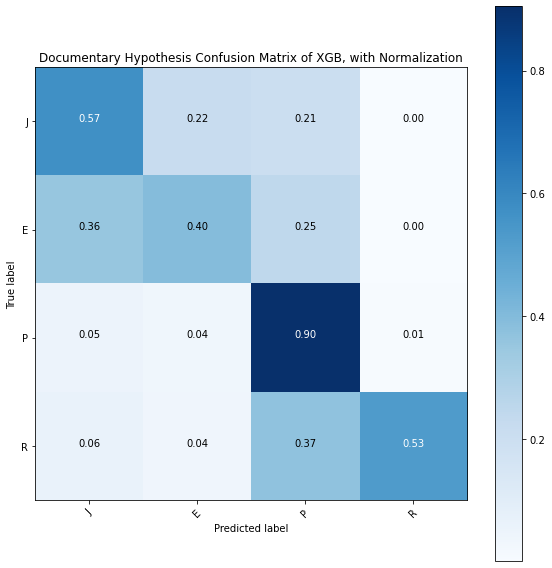

In [14]:
cnf_matrix = sum(cnf_dh_matrices)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['J', 'E', 'P', 'R'], title='Documentary Hypothesis Confusion Matrix of XGB, with Normalization', normalize=True)
plt.show()

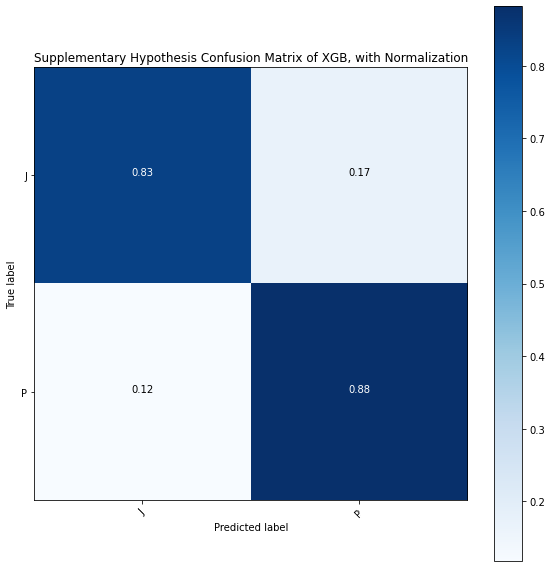

In [15]:
cnf_matrix = sum(cnf_sh_matrices)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['J', 'P'], title='Supplementary Hypothesis Confusion Matrix of XGB, with Normalization', normalize=True)
plt.show()

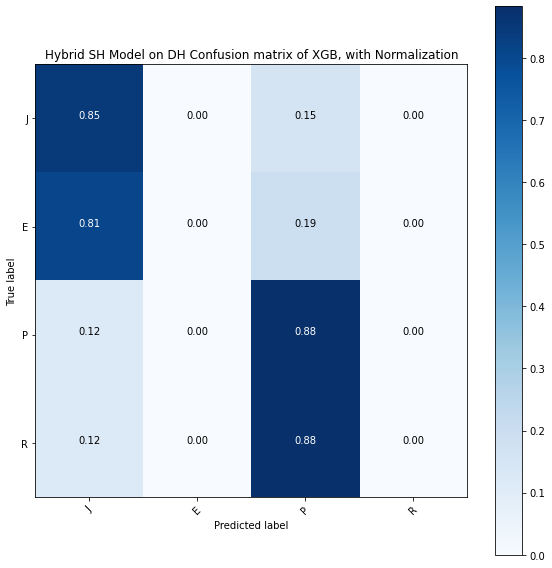

In [16]:
cnf_matrix = sum(cnf_hybrid_matrices)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['J', 'E', 'P', 'R'], title='Hybrid SH Model on DH Confusion Matrix of XGB, with Normalization', normalize=True)
plt.show()